# Setup
## Import Packages

In [34]:
import sys
import random

# Deep Learning
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, ConcatDataset
from itertools import chain
from torch import nn
from torch.utils.data import DataLoader
# from torchsummary import summary
# from torch.nn import functional as F


# Training
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# XGBoost / CatBoost
import xgboost as xgb
import catboost as cb

# DataFrame
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [35]:
X_train = pd.read_csv('/kaggle/input/houseprice/data/X_train.csv')
y_train = pd.read_csv('/kaggle/input/houseprice/data/y_train.csv')
X_test = pd.read_csv('/kaggle/input/houseprice/data/X_test.csv')

target_y = 'Price'
layer_name = 2

## Check GPU

In [36]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU


# Data Preprocessing
## Data Summary

In [37]:
print(X_train.columns)
y_train.drop('Index', axis=1, inplace=True)
# y_train = np.array(y_train).reshape(-1)

EDA_data = X_train.copy(deep=True)
# concat X_train and y_train
EDA_data['Price'] = y_train['Price']

train_shape = X_train.shape[0]

# transform to datetime

EDA_data['deal_date'] = pd.to_datetime((EDA_data['deal_year'] + 1911).astype(str) + ' ' + EDA_data['deal_month'].astype(str) + ' ' + EDA_data['deal_day'].astype(str), format='%Y %m %d')
EDA_data['built_date'] = (EDA_data['built_year'] + 1911).astype(str) + ' ' + EDA_data['built_month'].astype(str) + ' ' + EDA_data['built_day'].astype(str)
EDA_data.drop(['deal_year', 'deal_month', 'deal_day', 'built_year', 'built_month', 'built_day'], axis=1, inplace=True)

# if ['built_date'] == '1911 0 0', transfer it to '1911 1 1'
EDA_data.loc[EDA_data['built_date'] == '1911 0 0', 'built_date'] = '1911 1 1'
EDA_data['built_date'] = pd.to_datetime(EDA_data['built_date'], format='%Y %m %d', errors='coerce')
EDA_data.dropna(inplace=True)
print(EDA_data.shape)
print(EDA_data.dtypes)

Index(['Index', '土地移轉總面積平方公尺', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳',
       '建物現況格局-衛', '車位移轉總面積(平方公尺)', '車位總價元', '主建物面積', '附屬建物面積', '陽台面積',
       'Latitude', 'Longitude', 'deal_year', 'deal_month', 'deal_day',
       'built_year', 'built_month', 'built_day', 'total_floor', 'sell_floor',
       '鄉鎮市區_三峽區', '鄉鎮市區_三芝區', '鄉鎮市區_三重區', '鄉鎮市區_中和區', '鄉鎮市區_中山區', '鄉鎮市區_中正區',
       '鄉鎮市區_五股區', '鄉鎮市區_信義區', '鄉鎮市區_內湖區', '鄉鎮市區_八里區', '鄉鎮市區_北投區', '鄉鎮市區_南港區',
       '鄉鎮市區_土城區', '鄉鎮市區_坪林區', '鄉鎮市區_士林區', '鄉鎮市區_大同區', '鄉鎮市區_大安區', '鄉鎮市區_文山區',
       '鄉鎮市區_新店區', '鄉鎮市區_新莊區', '鄉鎮市區_松山區', '鄉鎮市區_板橋區', '鄉鎮市區_林口區', '鄉鎮市區_樹林區',
       '鄉鎮市區_永和區', '鄉鎮市區_汐止區', '鄉鎮市區_泰山區', '鄉鎮市區_淡水區', '鄉鎮市區_深坑區', '鄉鎮市區_瑞芳區',
       '鄉鎮市區_石碇區', '鄉鎮市區_石門區', '鄉鎮市區_萬華區', '鄉鎮市區_萬里區', '鄉鎮市區_蘆洲區', '鄉鎮市區_貢寮區',
       '鄉鎮市區_金山區', '鄉鎮市區_雙溪區', '鄉鎮市區_鶯歌區', '交易標的_房地(土地+建物)',
       '交易標的_房地(土地+建物)+車位', '建物型態_住宅大樓(11層含以上有電梯)', '建物型態_公寓(5樓含以下無電梯)',
       '建物型態_其他', '建物型態_店面(店鋪)', '建物型態_廠辦', '建物型態_華廈(10層含以下有電梯)', '建物型態_農舍',
       '建物型態_透天厝', '建物現況

### Find Distributions

0       2021-01-09
1       2021-11-02
2       2021-03-10
3       2021-07-27
4       2021-10-19
           ...    
29995   2021-06-20
29996   2021-10-27
29997   2021-07-19
29998   2021-01-20
29999   2021-09-18
Name: deal_date, Length: 29994, dtype: datetime64[ns]


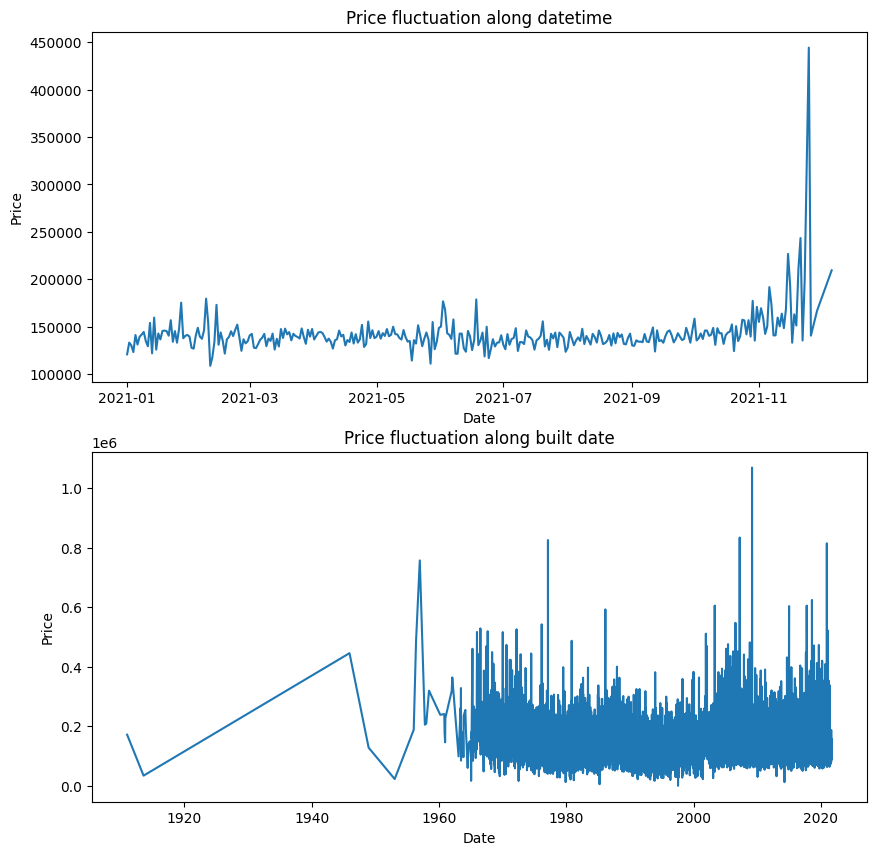

In [38]:
# find price fluctuation along datetime
print(EDA_data['deal_date'])

group_by_date = EDA_data.groupby('deal_date')['Price'].mean()

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(group_by_date)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].set_title('Price fluctuation along datetime')

group_by_date = EDA_data.groupby('built_date')['Price'].mean()
ax[1].plot(group_by_date)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[1].set_title('Price fluctuation along built date')

plt.show()

In [39]:
# # download chinese font for plt
# # import matplotlib
# # matplotlib.rc('font', family='Microsoft JhengHei')
# EDA_data.hist(bins=100, figsize=(20, 25))
# plt.show()

### Correlation

Price        1.000000
鄉鎮市區_大安區     0.332597
Longitude    0.294769
鄉鎮市區_中山區     0.217403
鄉鎮市區_信義區     0.212988
               ...   
鄉鎮市區_汐止區    -0.133834
建物現況格局-房    -0.134311
鄉鎮市區_淡水區    -0.240964
鄉鎮市區_石碇區          NaN
建物型態_農舍           NaN
Name: Price, Length: 80, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 37129 (\N{CJK UNIFIED IDEOGRAPH-9109}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 37806 (\N{CJK UNIFIED IDEOGRAPH-93AE}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.draw()
/opt

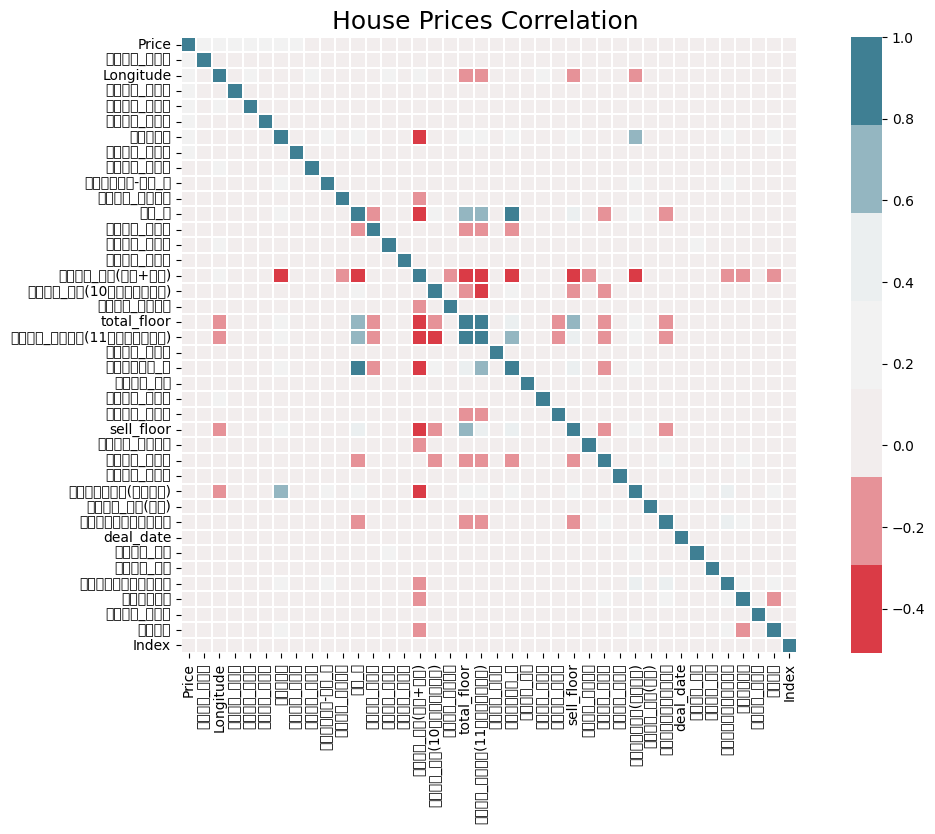

In [40]:
corr = EDA_data.corr()

# Select the top correlated features with 'Price'
top_corr = EDA_data[corr.nlargest(40, 'Price')['Price'].index].corr()

print(corr['Price'].sort_values(ascending=False))

plt.figure(figsize=(14,8))
plt.title('House Prices Correlation ', fontsize=18)
sns.heatmap(top_corr,annot=False,cmap=sns.diverging_palette(10, 220, sep=80, n=7),linewidths=0.2, square=True)
plt.show()

## Feature Engineering


In [41]:
# concat train, test
total_data = pd.concat([X_train, X_test], axis=0)

### Latitude & Longitude transformation

[ 1.1594281  -0.43059443 -0.09423041 ... -0.14675078  0.92453363
  1.52443594]


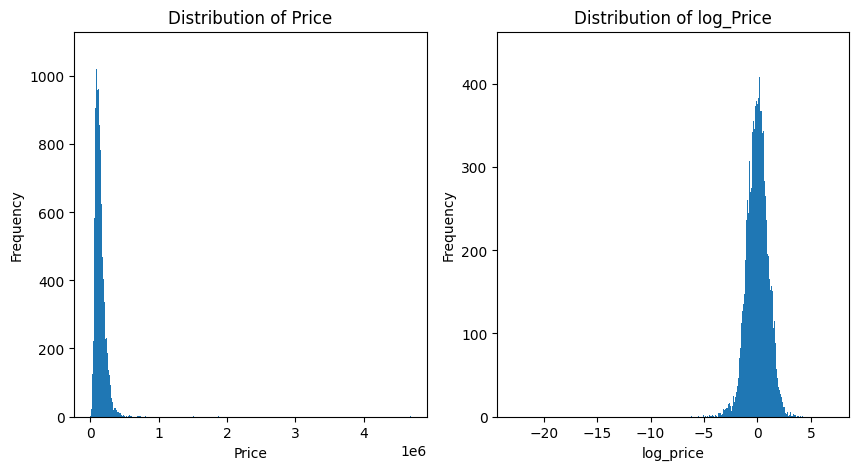

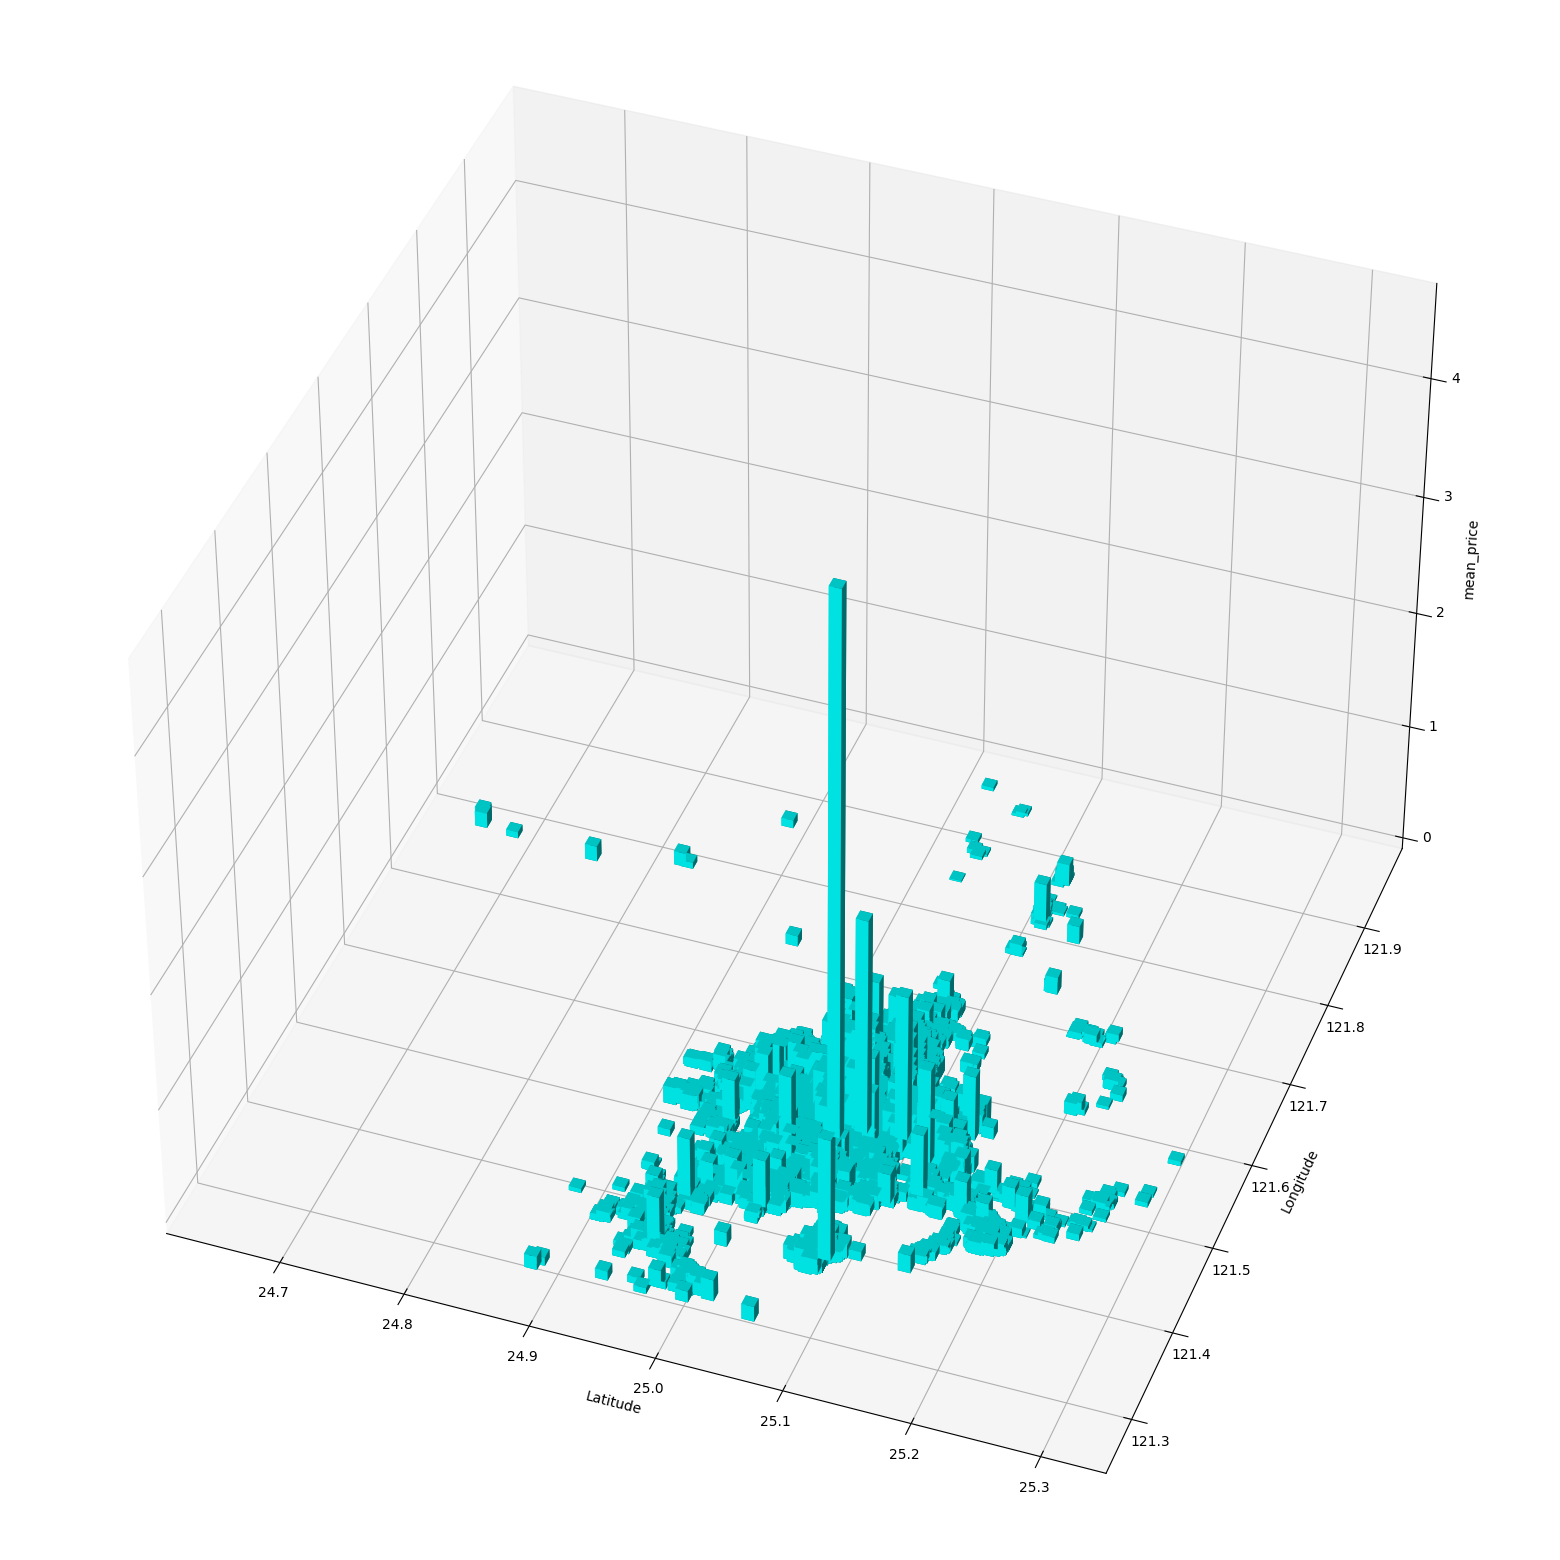

In [42]:
y_train['log_price'] = np.log1p(y_train['Price'])
# normalize
log_price_mean = y_train['log_price'].mean()
log_price_std = y_train['log_price'].std()
y_train['log_price'] = (y_train['log_price'] - log_price_mean) / log_price_std

print(y_train['log_price'].unique())

# print subplot of price and log price distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(y_train['Price'], bins=1000)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Price')

ax[1].hist(y_train['log_price'], bins=1000)
ax[1].set_xlabel('log_price')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of log_Price')
plt.show()


grouped_by_location = EDA_data.groupby(['Latitude', 'Longitude'])['Price'].mean().reset_index(name='mean_price')

def plot_3D_distribution(df, x_column, y_column, z_column, rotation_angle_1 = 50, rotation_angle_2 = 290, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(df[x_column], df[y_column], np.zeros(len(df[z_column])), 0.01, 0.01, df[z_column], color='aqua')
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_zlabel(z_column)

    # rotate the 3D bar plot
    ax.view_init(rotation_angle_1, rotation_angle_2)
    plt.show()

plot_3D_distribution(grouped_by_location, 'Latitude', 'Longitude', 'mean_price', 40)

25.0489981
121.4995859


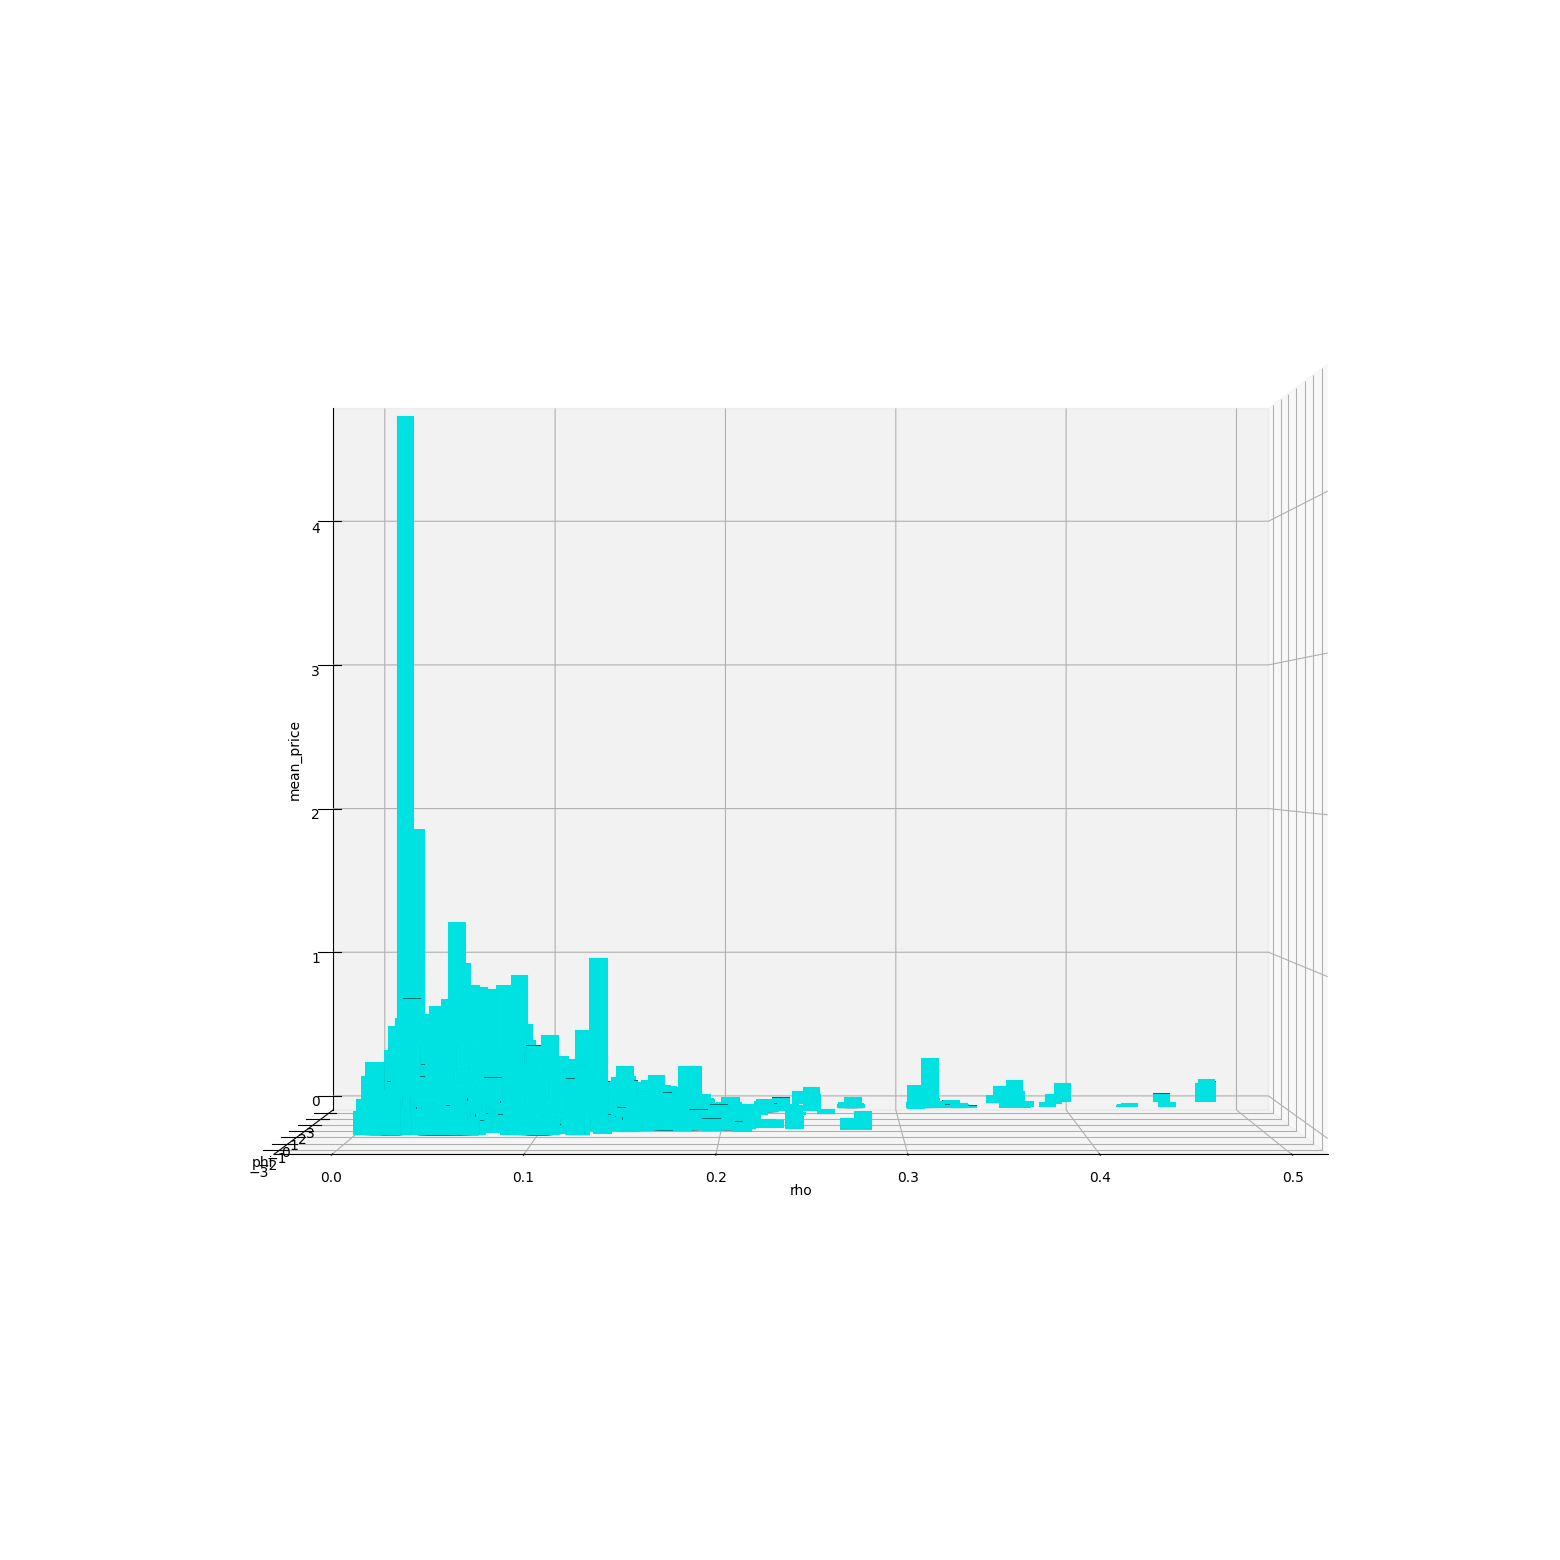

In [43]:
# transform latitude and longitude to polar coordinates
def cart2(x, y, r = True):
    if r:
        rho = np.sqrt(x**2 + y**2)
        return rho
    phi = np.arctan2(y, x)
    return phi

# price_threshold = grouped_by_location['mean_price'].median()  # You can set the threshold based on your criteria
# optimal_center_point = optimal_center(grouped_by_location)
# print("Optimal Center Point (latitude, longitude):", optimal_center_point)

print(EDA_data['Latitude'].median())
print(EDA_data['Longitude'].median())
EDA_data['Latitude_normalized'] = EDA_data['Latitude'] - EDA_data['Latitude'].median()
EDA_data['Longitude_normalized'] = EDA_data['Longitude'] -  EDA_data['Longitude'].median()
EDA_data['rho'] = cart2(EDA_data['Latitude_normalized'], EDA_data['Longitude_normalized'], r = True)
EDA_data['phi'] = cart2(EDA_data['Latitude_normalized'], EDA_data['Longitude_normalized'], r = False)
total_data['Latitude_normalized'] = total_data['Latitude'] - EDA_data['Latitude'].median()
total_data['Longitude_normalized'] = total_data['Longitude'] -  EDA_data['Longitude'].median()
total_data['rho'] = cart2(total_data['Latitude_normalized'], total_data['Longitude_normalized'], r = True)
total_data['phi'] = cart2(total_data['Latitude_normalized'], total_data['Longitude_normalized'], r = False)

grouped_by_polar_location = EDA_data.groupby(['rho', 'phi'])['Price'].mean().reset_index(name='mean_price')
plot_3D_distribution(grouped_by_polar_location, 'rho', 'phi', 'mean_price', 0, 270)
total_data.drop(['Latitude_normalized', 'Longitude_normalized'], axis = 1, inplace = True)

### Aggregate or Add Categorial
#### Sell to Total

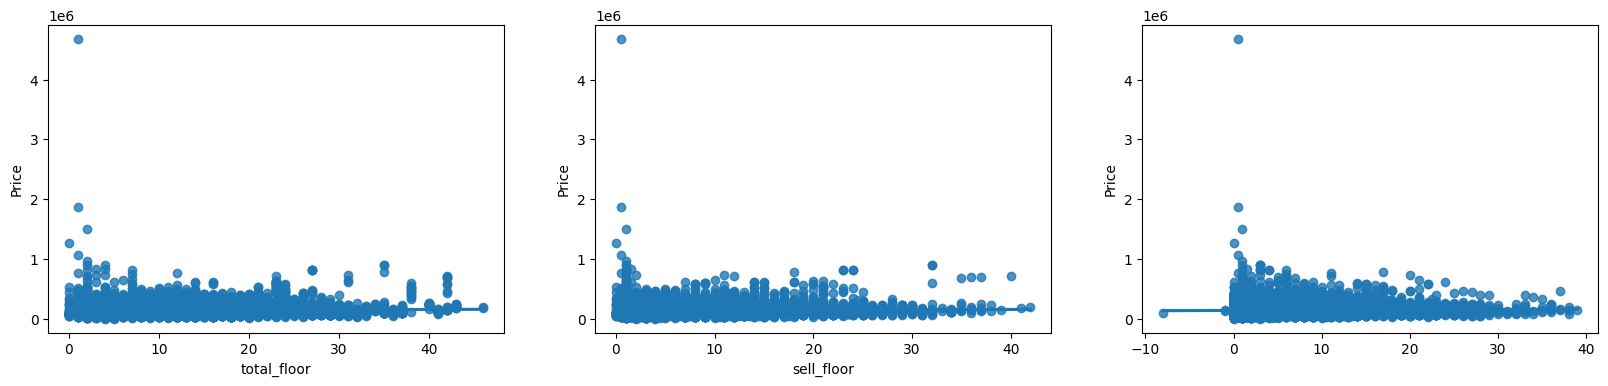

In [44]:
# Create subplots and figure
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(20, 4)

sns.regplot(x=EDA_data['total_floor'], y=EDA_data['Price'], ax=ax1)
sns.regplot(x=EDA_data['sell_floor'], y=EDA_data['Price'], ax=ax2)
sns.regplot(x=(EDA_data['total_floor'] - EDA_data['sell_floor']), y=EDA_data['Price'], ax=ax3)

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.4)

# Show the plots
plt.show()

total_data['SellToTotal'] = total_data['total_floor'] - total_data['sell_floor']

#### total_area

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29289 (\N{CJK UNIFIED IDEOGRAPH-7269}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

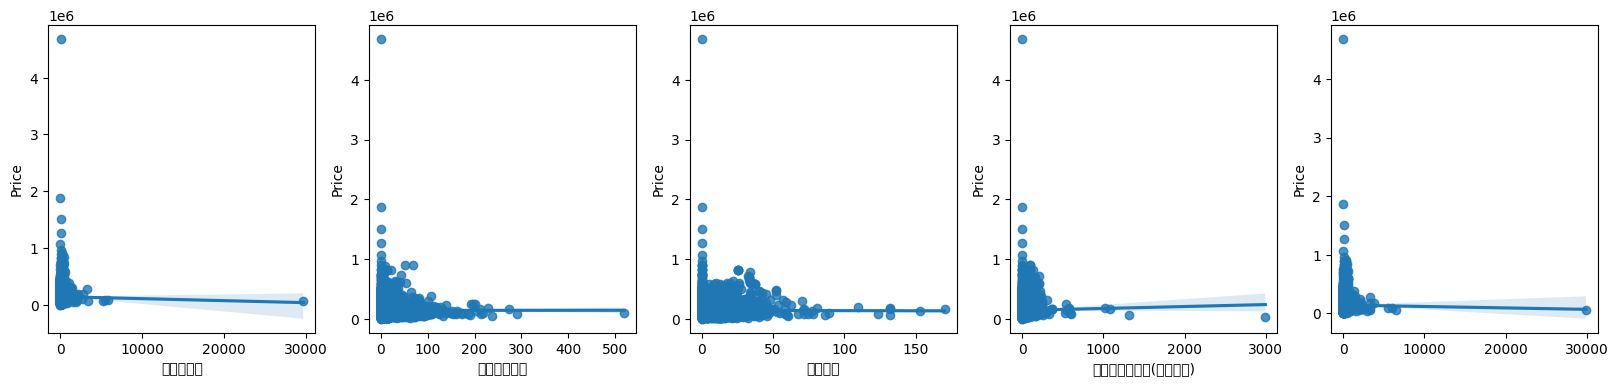

In [45]:
# Create subplots and figure
figure, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5)
figure.set_size_inches(20, 4)

sns.regplot(x=EDA_data['主建物面積'], y=EDA_data['Price'], ax=ax1)
sns.regplot(x=EDA_data['附屬建物面積'], y=EDA_data['Price'], ax=ax2)
sns.regplot(x=(EDA_data['陽台面積']), y=EDA_data['Price'], ax=ax3)
sns.regplot(x=(EDA_data['車位移轉總面積(平方公尺)']), y=EDA_data['Price'], ax=ax4)
sns.regplot(x=(EDA_data['陽台面積'] + EDA_data['附屬建物面積'] + EDA_data['主建物面積'] + EDA_data['車位移轉總面積(平方公尺)']), y=EDA_data['Price'], ax=ax5)

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.4)

# Show the plots
plt.show()

total_data['total_area'] = total_data['陽台面積'] + total_data['附屬建物面積'] + total_data['主建物面積']

In [46]:
total_data['No_Balcony'] = (total_data['陽台面積'] == 0).astype(int)
total_data['No_Aux_Building'] = (total_data['附屬建物面積'] == 0).astype(int)
total_data['No_Built_Date'] = (total_data['built_year'] == 0).astype(int)

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22303 (\N{CJK UNIFIED IDEOGRAPH-571F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36681 (\N{CJK UNIFIED IDEOGRAPH-8F49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

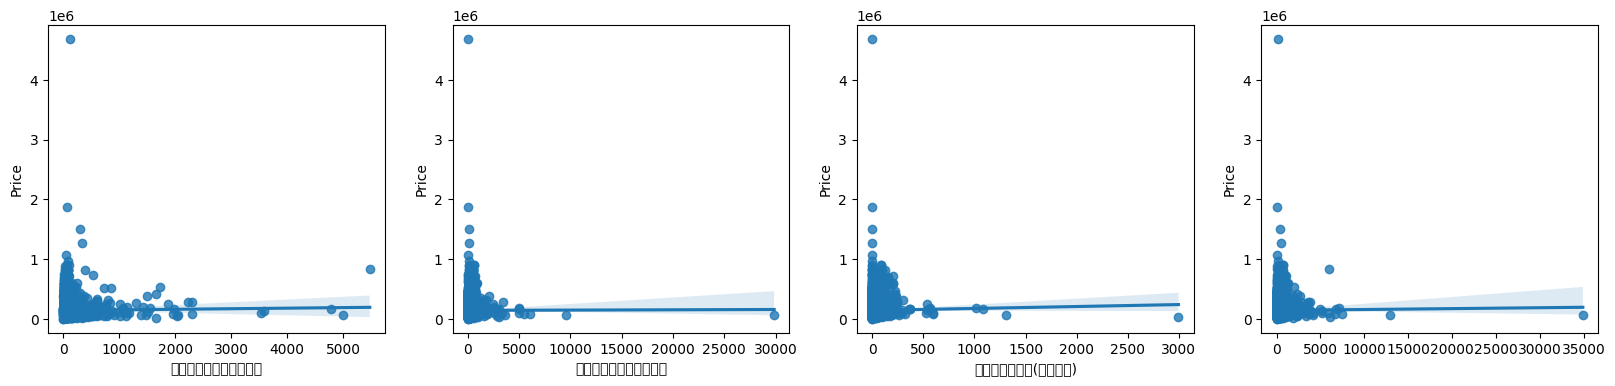

In [47]:
# Create subplots and figure
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches(20, 4)

sns.regplot(x=EDA_data['土地移轉總面積平方公尺'], y=EDA_data['Price'], ax=ax1)
sns.regplot(x=EDA_data['建物移轉總面積平方公尺'], y=EDA_data['Price'], ax=ax2)
sns.regplot(x=(EDA_data['車位移轉總面積(平方公尺)']), y=EDA_data['Price'], ax=ax3)
sns.regplot(x=(EDA_data['土地移轉總面積平方公尺'] + EDA_data['建物移轉總面積平方公尺'] + EDA_data['車位移轉總面積(平方公尺)']), y=EDA_data['Price'], ax=ax4)

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.4)

# Show the plots
plt.show()

total_data['總移轉面積'] = total_data['土地移轉總面積平方公尺'] + total_data['建物移轉總面積平方公尺'] + total_data['車位移轉總面積(平方公尺)']

In [48]:
# total_data['deal_date'] = pd.to_datetime((total_data['deal_year'] + 1911).astype(str) + ' ' + total_data['deal_month'].astype(str) + ' ' + total_data['deal_day'].astype(str), format='%Y %m %d')
# total_data['built_date'] = (total_data['built_year'] + 1911).astype(str) + ' ' + total_data['built_month'].astype(str) + ' ' + total_data['built_day'].astype(str)
# # transfer to the amount of day
# total_data['deal_date'] = (total_data['deal_date'] - total_data['deal_date'].min()).dt.days
# total_data['built_date'] = (total_data['built_date'] - total_data['built_date'].min()).dt.days
# total_data.drop(['deal_year', 'deal_month', 'deal_day', 'built_year', 'built_month', 'built_day'], axis=1, inplace=True)


## Outlier Handling

In [49]:
# # Find Outliers by Isolation Forest

# def RemoveOutlier(target):
#     clf = IsolationForest()
#     clf.fit(target)
#     target['prediction'] = clf.fit_predict(target)
#     y_train = y_train[target['prediction'] > 0]
#     target = target[target['prediction'] > 0]
#     target.drop('prediction', axis=1, inplace=True)

# outlier_df = X_train[['鄉鎮市區_三峽區', '鄉鎮市區_三芝區']]
# outlier_df['District'] = X_train[['鄉鎮市區_三峽區', '鄉鎮市區_三芝區', '鄉鎮市區_三重區', '鄉鎮市區_中和區', '鄉鎮市區_中山區', '鄉鎮市區_中正區',
#        '鄉鎮市區_五股區', '鄉鎮市區_信義區', '鄉鎮市區_內湖區', '鄉鎮市區_八里區', '鄉鎮市區_北投區', '鄉鎮市區_南港區',
#        '鄉鎮市區_土城區', '鄉鎮市區_坪林區', '鄉鎮市區_士林區', '鄉鎮市區_大同區', '鄉鎮市區_大安區', '鄉鎮市區_文山區',
#        '鄉鎮市區_新店區', '鄉鎮市區_新莊區', '鄉鎮市區_松山區', '鄉鎮市區_板橋區', '鄉鎮市區_林口區', '鄉鎮市區_樹林區',
#        '鄉鎮市區_永和區', '鄉鎮市區_汐止區', '鄉鎮市區_泰山區', '鄉鎮市區_淡水區', '鄉鎮市區_深坑區', '鄉鎮市區_瑞芳區',
#        '鄉鎮市區_石碇區', '鄉鎮市區_石門區', '鄉鎮市區_萬華區', '鄉鎮市區_萬里區', '鄉鎮市區_蘆洲區', '鄉鎮市區_貢寮區',
#        '鄉鎮市區_金山區', '鄉鎮市區_雙溪區', '鄉鎮市區_鶯歌區']].idxmax(axis=1).str.replace('鄉鎮市區_', '')

# outlier_df.drop(['鄉鎮市區_三峽區', '鄉鎮市區_三芝區'], axis=1, inplace=True)
# outlier_df['Price'] = y_train['Price']
# grouped_by_district = outlier_df.groupby('District')
# out_indices = []
# for key, i in grouped_by_district:
#     i['predictions'] = (i['Price'] <= (np.mean(i['Price'])- 1.5* np.std(i['Price']))) | (i['Price'] > (np.mean(i['Price'])+ 1.5*np.std(i['Price'])))
#     # get indices of outliers
#     out_indices.extend(i[i['predictions'] == 0].index)

## Normalization

In [50]:
total_data.drop(['Index', 'deal_year', 'deal_month', 'deal_day', 'built_month', 'built_day','電梯_無', '有無管理組織_無', '建物現況格局-隔間_無','建物型態_其他', '車位類別_其他','交易標的_房地(土地+建物)+車位', '鄉鎮市區_鶯歌區'], axis=1, inplace=True)
# print(total_data.columns)
# Normalize
numeric_features = ['總移轉面積', '土地移轉總面積平方公尺', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳',
       '建物現況格局-衛', '車位移轉總面積(平方公尺)', '車位總價元', '主建物面積', '附屬建物面積', '陽台面積',
       'Latitude', 'Longitude', 'total_floor', 'sell_floor', 'total_area', 'rho', 'phi', 'built_year', 'SellToTotal']
categorical_features = ['鄉鎮市區_三峽區', '鄉鎮市區_三芝區', '鄉鎮市區_三重區', '鄉鎮市區_中和區', '鄉鎮市區_中山區', '鄉鎮市區_中正區',
       '鄉鎮市區_五股區', '鄉鎮市區_信義區', '鄉鎮市區_內湖區', '鄉鎮市區_八里區', '鄉鎮市區_北投區', '鄉鎮市區_南港區',
       '鄉鎮市區_土城區', '鄉鎮市區_坪林區', '鄉鎮市區_士林區', '鄉鎮市區_大同區', '鄉鎮市區_大安區', '鄉鎮市區_文山區',
       '鄉鎮市區_新店區', '鄉鎮市區_新莊區', '鄉鎮市區_松山區', '鄉鎮市區_板橋區', '鄉鎮市區_林口區', '鄉鎮市區_樹林區',
       '鄉鎮市區_永和區', '鄉鎮市區_汐止區', '鄉鎮市區_泰山區', '鄉鎮市區_淡水區', '鄉鎮市區_深坑區', '鄉鎮市區_瑞芳區',
       '鄉鎮市區_石碇區', '鄉鎮市區_石門區', '鄉鎮市區_萬華區', '鄉鎮市區_萬里區', '鄉鎮市區_蘆洲區', '鄉鎮市區_貢寮區',
       '鄉鎮市區_金山區', '鄉鎮市區_雙溪區', '電梯_有', '建物型態_住宅大樓(11層含以上有電梯)', '建物型態_公寓(5樓含以下無電梯)', '建物型態_店面(店鋪)', '建物型態_廠辦', '建物型態_華廈(10層含以下有電梯)', '建物型態_農舍',
       '建物型態_透天厝', '建物現況格局-隔間_有', '有無管理組織_有',
       '車位類別_一樓平面', '車位類別_升降平面', '車位類別_升降機械', '車位類別_坡道平面',
       '車位類別_坡道機械', '車位類別_塔式車位', '交易標的_房地(土地+建物)', 'No_Balcony', 'No_Aux_Building', 'No_Built_Date']

In [51]:
X_train = total_data[:train_shape]
X_test = total_data[train_shape:]

# X_train = X_train[X_train.index.isin(out_indices)]
# y_train = y_train[y_train.index.isin(out_indices)]

mean = X_train[numeric_features].mean()
std = X_train[numeric_features].std()

X_train[numeric_features] = (X_train[numeric_features] - mean) / std
X_test[numeric_features] = (X_test[numeric_features] - mean) / std

/tmp/ipykernel_11103/3887558662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_features] = (X_train[numeric_features] - mean) / std
/tmp/ipykernel_11103/3887558662.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = (X_test[numeric_features] - mean) / std


In [52]:
def to_submission_csv(y_pred):
    test_data  = pd.read_csv('/kaggle/input/houseprice/data/X_test.csv')
    test_ids = test_data['Index']

    # convert test_ids to a dataframe
    submission = pd.DataFrame(test_ids)
    submission['Price'] = y_pred

    print(submission.shape)
    submission.to_csv('/kaggle/working/predictions.csv',index=False)

In [53]:
class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:  # For test set, there are no labels
            return self.X[idx]
        else:
            return self.X[idx], self.y[idx]

# X_train = total_data[:train_shape]
# X_test = total_data[train_shape:]

# mean = X_train[numeric_features].mean()
# std = X_train[numeric_features].std()
# X_train[numeric_features] = (X_train[numeric_features] - mean) / std
# X_test[numeric_features] = (X_test[numeric_features] - mean) / std

# Split the data
random_seed = 42
y_train = y_train[target_y]
y_train = np.array(y_train).reshape(-1)
y_train_full = y_train
print(X_train.shape)
print(y_train.shape)
X_train_numpy = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
trainset = TabularDataset(X_train_numpy, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train.values,
                                                      y_train,
                                                      test_size=0.2,
                                                      random_state=random_seed)

# Convert to PyTorch tensors

X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_train_full = torch.tensor(y_train_full, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_valid, y_valid)

# Convert test data to PyTorch tensor
test_dataset = TabularDataset(X_test)
k_fold_trainset = ConcatDataset([train_dataset, val_dataset])

(30000, 78)
(30000,)


In [54]:
print(X_train.shape)
print(X_valid.shape)

torch.Size([24000, 78])
torch.Size([6000, 78])


# Modeling

## MLP

In [55]:

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
    Specify hidden layers and size using (n1,n2,..,nm) notation
    where there are m layers, and ni is the number of nodes on
    layer i.
  '''
  def __init__(self,
               hidden_layers,
               outputSize=10,
               lr=0.01,
               lossfn=nn.CrossEntropyLoss(),
               target_type='long'):
    super().__init__()

    self.lr = lr
    self.lossfn = lossfn
    self.target_type = target_type

    # Create the MLP
    assert len(hidden_layers) > 0 and hidden_layers

    # # Initialize layers
    # layers = [nn.Flatten()]  # Start with flattening layer

    # # Add hidden layers specified by hidden_layers
    # input_sizes = iter(hidden_layers)
    # output_sizes = iter(hidden_layers[1:])
    # for input_size, output_size in zip(input_sizes, output_sizes):
    #     layers.extend([
    #         nn.Linear(input_size, output_size),
    #         nn.BatchNorm1d(output_size),
    #         nn.ReLU()
    #     ])

    # # Add the output layer
    # layers.append(nn.Linear(hidden_layers[-1], outputSize))

    self.layers = nn.Sequential(nn.Flatten())
    self.layers.add_module('hidden', self.hiddenLayers(hidden_layers))
    self.layers.add_module('output', nn.Linear(hidden_layers[-1],outputSize))

    # # Create the Sequential model
    # self.layers = nn.Sequential(*layers)

  # Create the hidden layers, except the output layer
  def hiddenLayers(self,hidden_layers):
    layers = ((nn.LazyLinear(outputSize),nn.LazyBatchNorm1d(),nn.ReLU()) for outputSize in hidden_layers)
    layers = tuple(chain.from_iterable(layers))
    return nn.Sequential(*layers)

  ## The forward step
  def forward(self, X):
    # X1 = self.layers[0](X)  # Flatten
    # print(f"After Flatten: {X1.shape}")
    # X2 = self.layers[1](X1)  # First LazyLinear
    # print(f"After first LazyLinear: {X2.shape}")
    # Computes the output given the input X
    return self.layers(X)

  ## The loss function
  def loss(self, y_hat, y):
    target = y.float().type(torch.FloatTensor)
    target = target.to(y_hat.device)
    mae = torch.mean(torch.abs(y_hat - target))
    return mae

  ## The optimization algorithm
  #  Let's this time use Adam, which is the most commonly used optimizer in neural networks
  def configure_optimizers(self,weight_decay=0.01):
    # return torch.optim.SGD(self.parameters(), self.lr)
    return torch.optim.Adam(self.parameters(),
                            self.lr,
                            weight_decay=weight_decay,
                            betas=(0.9, 0.999))

  def setLearningRate(self,lr):
    self.lr = lr

  def getLearningRate(self):
    return self.lr

  def getName(self):
    return type(self).__name__

  def extract_features(self, X, layer_name):
    # Set the model to evaluation mode
    self.eval()

    # Pass the input through the model until the specified layer
    feature_extractor = nn.Sequential(*list(self.layers.children())[:layer_name])
    features = feature_extractor(X)

    # Convert features to numpy array if needed
    return features.detach().cpu().numpy()


## Training

In [56]:
class Trainer:

  def __init__(self,
               writer=None,
               n_epochs=3,
               verbose=False,
               ignore_accuracy=False,
               input_as_target=False,
               compute_psnr=False):
    self.max_epochs = n_epochs
    self.accuracies = []
    self.verbose = verbose

    # SummaryWriter for TensorBoard
    self.writer = writer

    # this for regression problems
    self.ignore_accuracy = ignore_accuracy

    # this for autoencoder output comparisons
    self.compute_psnr = compute_psnr

    # setting this true is for autoencoders that use the inputs
    # to train the output of a encoder-decoder architecture
    self.input_as_target = input_as_target
    return

  # Add a new function to get the target type
  def get_target_type(self):
    return torch.long if self.target_type == 'long' else torch.float

  # The fitting step
  def fit(self, model, train_loader, val_loader, weight_decay=0.01):

    self.training_data    = train_loader
    self.validation_data  = val_loader
    self.epoch_stats = {'Training':[],
                        'Validation':[],
                        'Accuracy':[],
                        'PSNR':[]}
    self.exclude = []

    # configure the optimizer
    self.optimizer = model.configure_optimizers(weight_decay=weight_decay)
    self.model     = model

    if self.verbose:
      print(f'Starting {model.getName()} model training for {self.max_epochs} epochs:')

    for epoch in range(self.max_epochs):

      # Compute training loss
      tr = self.fit_epoch()
      # Compute validation loss and accuracy
      acc, val, psnr = self.validate()

      self.epoch_stats['Training'].append(tr)
      self.epoch_stats['Accuracy'].append(acc)
      self.epoch_stats['Validation'].append(val)
      self.epoch_stats['PSNR'].append(psnr)

      if self.writer:
        # send loss to TensorBoard
        self.writer.add_scalars("Loss",{'validation': val,'training': tr},epoch)
        # send accuracy to TensorBoard
        if not self.ignore_accuracy:
           self.writer.add_scalar("Accuracy", acc, epoch)
        # send psnr to TensorBoard
        if self.compute_psnr:
          self.writer.add_scalar("PSNR", psnr, epoch)

      if self.verbose:
        print(f'\tLoss at epoch {epoch}: T {tr:,.3f} V {val:,.3f}')
      if not self.ignore_accuracy:
        print(f'\tAccuracy after epoch {epoch}: {acc*100:.3f} %')
      if self.compute_psnr:
        print(f'\tPSNR after epoch {epoch}: {psnr:.3f} %\n')
        plot_ae_outputs( self.model.encoder, self.model.decoder, n=10)

    if self.verbose:
      print("Training process has finished.")
      plot_curves(self.epoch_stats,
                  "Epoch",
                  "Average Loss",
                   ["PSNR","Accuracy"] if self.ignore_accuracy else ["PSNR"])

    return {  'epoch': self.max_epochs,
              'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'statistics': self.epoch_stats}

  def fit_epoch(self):

    # set model to training mode
    self.model.train()

    # current_loss = 0.0
    all_losses = []

    # iterate over the DataLoader for training data
    for i, data in enumerate(self.training_data,0):

      # Get input and send mini-batch to GPU
      input = data[0].to(device)
      target = input if self.input_as_target else data[1].to(device)
      #print(target.shape)

      # Clear gradient buffers because we don't want any gradient from previous
      # epoch to carry forward, dont want to cummulate gradients
      self.optimizer.zero_grad()

      # get output from the model, given the inputs
      # never call forward directly
      output = self.model(input)
      #print(output.shape)

      # get loss for the predicted output
      loss = self.model.loss(output, target)

      # save the loss for plotting
      all_losses.append(loss.item())

      # get gradients w.r.t the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimizer.step()

      # Let's print some statisics
      # current_loss += loss.item()
      # if i % 500 == 499:
      #     # print('Loss after mini-batch %5d: %.3f' %
      #     #        (i + 1, current_loss / 500))
      #     current_loss = 0.0

    return sum(all_losses)/len(all_losses)  # return average loss

  def validate(self):
      self.model.eval()  # Set the model to evaluation mode

      correct = 0
      total = 0
      avg_loss = 0.
      avg_psnr = 0.
      accuracy = 0.

      with torch.no_grad():  # Do not compute gradients

          for data in self.validation_data:

              input = data[0].to(device)
              target = input if self.input_as_target else data[1].to(device)

              output = self.model(input)

              # get loss for the predicted output
              avg_loss += self.model.loss(output,target)

              # calculate psnr for autoencoding problems
              if self.compute_psnr:
                avg_psnr += psnr(output, target)

              # calculate accuracy for classification problems
              if not self.ignore_accuracy:
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

      if not self.ignore_accuracy:
        accuracy = correct / total

      if isinstance(avg_loss, torch.Tensor):
          # Convert tensor to a float
          avg_loss = float(avg_loss.item())

      avg_loss /= len(self.validation_data)

      if isinstance(avg_psnr, torch.Tensor):
          # Convert tensor to a float
          avg_psnr = float(avg_psnr.item())

      avg_psnr /= len(self.validation_data)

      return accuracy, avg_loss, avg_psnr




def train(model,
          n_epochs,
          train_dataset,
          val_dataset,
          batch_size,
          weight_decay=1e-05,
          writer=None,
          use_saved_weights=False,
          new_lr=None,
          verbose=False,
          ignore_accuracy=False,
          input_as_target=False,
          compute_psnr=False):

  # Create DataLoaders for each set
  train_loader = DataLoader(train_dataset,
                            shuffle=True,
                            batch_size=batch_size,
                            num_workers=2)

  val_loader = DataLoader(val_dataset,
                          shuffle=True,
                          batch_size=batch_size,
                          num_workers=2)

  # Check if the weights file exists, if true, fine tune learning rate
  if 'MODEL_PATH' in globals() and os.path.isfile(MODEL_PATH) and use_saved_weights:

      # Load the model from the file
      checkpoint = torch.load(MODEL_PATH)
      # print(f'Saved model: {MODEL_PATH}')

      model.load_state_dict(checkpoint['model_state_dict'])
      if verbose:
        print(f'Loaded model weights')

      optimizer = model.configure_optimizers()
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      # print(f'Loaded optimizer parameters')

      # Fine tuning the learning rate
      learning_rate = new_lr if new_lr else model.getLearningRate()

      for param_group in optimizer.param_groups:
          param_group['lr'] = learning_rate
      # print(f'Learning rate: {learning_rate} Epochs: {n_epochs}')
  else:
      if verbose:
        print("No weights file found. Using randomly initialized weights.\n")

  # Training the network
  # Creating the trainer class
  trainer = Trainer(writer,
                    n_epochs=n_epochs,
                    verbose=verbose,
                    ignore_accuracy=ignore_accuracy,
                    input_as_target=input_as_target,
                    compute_psnr=compute_psnr)

  # Training the model
  checkpoint = trainer.fit(model, train_loader, val_loader, weight_decay)

  # Plot the results for average training and validation loss

  return model, trainer, checkpoint

# Tuning

In [57]:
def logScale(a,b):
  assert a < b
  lb = np.log10(a)
  ub = np.log10(b)
  return np.arange(lb,ub,0.5)

def RandomLayers(layers,nodes):
  hidden_layers = []
  l = random.choice(layers)
  for layer in range(l):
    n = random.choice(nodes)
    hidden_layers.append(n)
  return tuple(hidden_layers)

def RandomChoice(hyperparams):
  return { key:random.choice(value) for _,(key,value) in enumerate(hyperparams.items()) }

In [58]:
def k_fold(k,
           model,
           num_epochs,
           trainset,
           batch_size,
           weight_decay,
           learning_rate,
           verbose=False,
           ignore_accuracy=True,
           input_as_target=False,
           compute_psnr=False):

    accum_train_loss, accum_valid_loss = 0, 0

    assert k <= len(trainset)
    for i in range(k):

        # Get the ith fold
        train_dataset, val_dataset = get_k_fold_data(k, i, trainset)

        # Train using it num_epochs times
        model, _, checkpoint = train(model,
                                     num_epochs,
                                     train_dataset,
                                     val_dataset,
                                     batch_size,
                                     weight_decay,
                                     writer=None,
                                     new_lr=None,
                                     use_saved_weights=False,
                                     verbose=verbose,
                                     ignore_accuracy=ignore_accuracy,
                                     input_as_target=input_as_target,
                                     compute_psnr=compute_psnr)

        # Retrieve the statistics for the ith fold
        # which contains num_epochs
        stats = checkpoint['statistics']
        avg_train_loss = np.mean(stats['Training'])
        avg_valid_loss = np.mean(stats['Validation'])

        accum_train_loss += avg_train_loss
        accum_valid_loss += avg_valid_loss

        if verbose:
          print('fold %d/%d, epochs: %d, train loss: %f, valid loss: %f\n' % (
              i, k, num_epochs, avg_train_loss, avg_valid_loss))

    return accum_train_loss/k, accum_valid_loss/k

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


	Loss at epoch 0: T 139,662.089 V 138,704.225
	Loss at epoch 1: T 138,458.076 V 137,614.913
	Loss at epoch 2: T 136,808.930 V 135,111.288
	Loss at epoch 3: T 133,326.966 V 131,047.325
	Loss at epoch 4: T 128,830.813 V 126,670.000
Training process has finished.


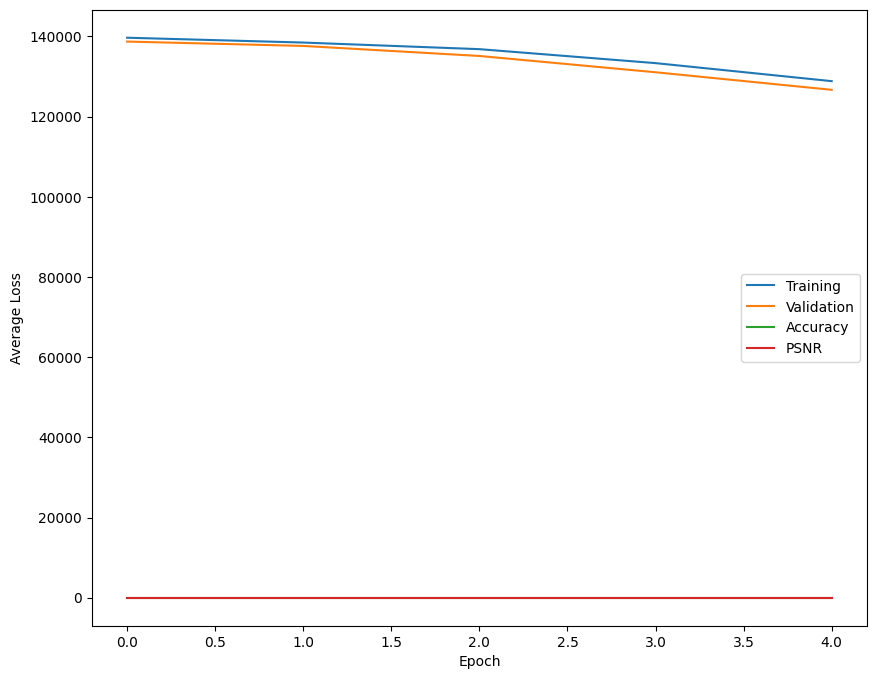

fold 0/3, epochs: 5, train loss: 135417.374648, valid loss: 133829.550000

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 124,376.833 V 121,977.375
	Loss at epoch 1: T 120,231.806 V 117,717.450
	Loss at epoch 2: T 115,128.171 V 113,362.712
	Loss at epoch 3: T 110,026.167 V 107,979.637
	Loss at epoch 4: T 103,727.163 V 103,694.381
Training process has finished.


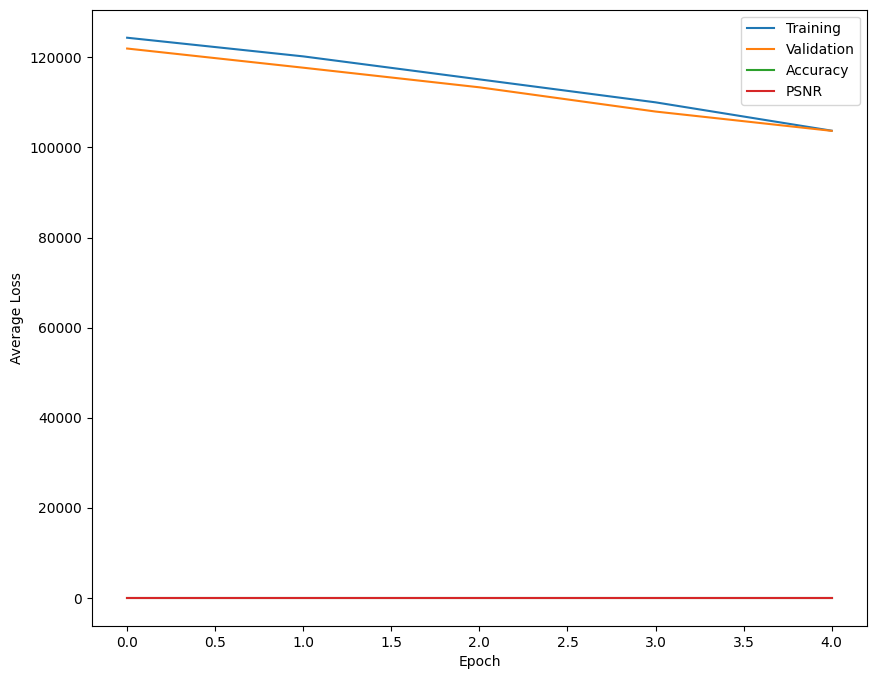

fold 1/3, epochs: 5, train loss: 114698.027773, valid loss: 112946.311250

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 97,496.806 V 95,709.913
	Loss at epoch 1: T 91,400.144 V 89,446.406
	Loss at epoch 2: T 85,467.843 V 82,610.500
	Loss at epoch 3: T 79,632.375 V 73,842.456
	Loss at epoch 4: T 74,106.672 V 71,891.744
Training process has finished.


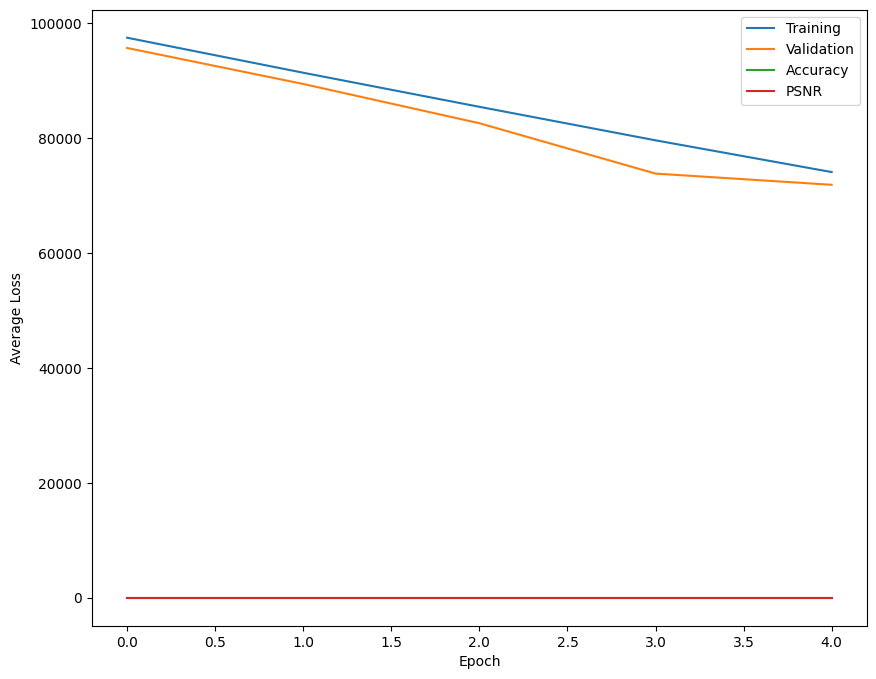

fold 2/3, epochs: 5, train loss: 85620.768047, valid loss: 82700.203750

-- Sample 0/5 Average Training Loss: 111,912.06
-- Sample 0/5 Difference with Validation: 2,086.70

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 128,664.082 V 92,373.790
	Loss at epoch 1: T 74,548.041 V 60,249.446
	Loss at epoch 2: T 53,137.871 V 52,753.799
	Loss at epoch 3: T 52,445.277 V 52,841.248
	Loss at epoch 4: T 52,384.115 V 52,770.742
Training process has finished.


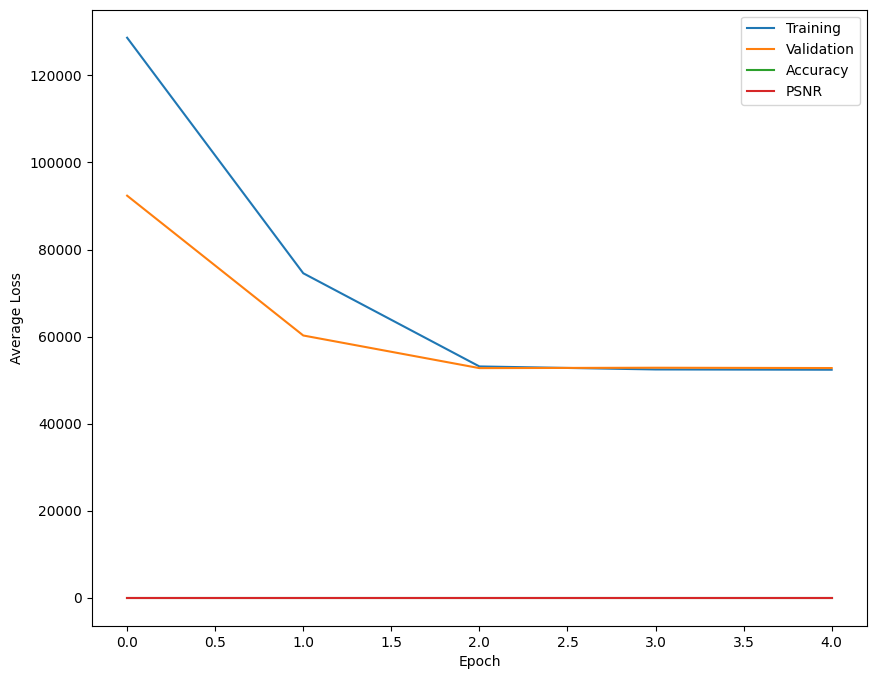

fold 0/3, epochs: 5, train loss: 72235.877281, valid loss: 62197.805096

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 52,969.185 V 51,868.580
	Loss at epoch 1: T 52,955.101 V 51,662.889
	Loss at epoch 2: T 52,901.703 V 52,073.271
	Loss at epoch 3: T 52,910.758 V 51,968.484
	Loss at epoch 4: T 52,955.708 V 51,717.268
Training process has finished.


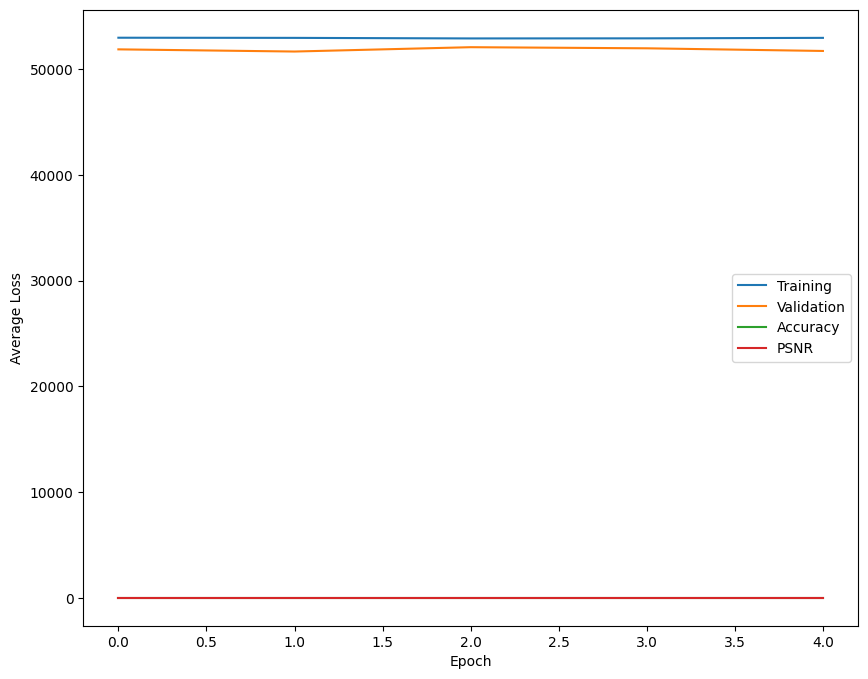

fold 1/3, epochs: 5, train loss: 52938.491069, valid loss: 51858.098089

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 52,199.766 V 53,257.003
	Loss at epoch 1: T 52,166.493 V 53,006.930
	Loss at epoch 2: T 52,174.581 V 53,199.468
	Loss at epoch 3: T 52,171.462 V 53,089.443
	Loss at epoch 4: T 52,162.765 V 53,168.379
Training process has finished.


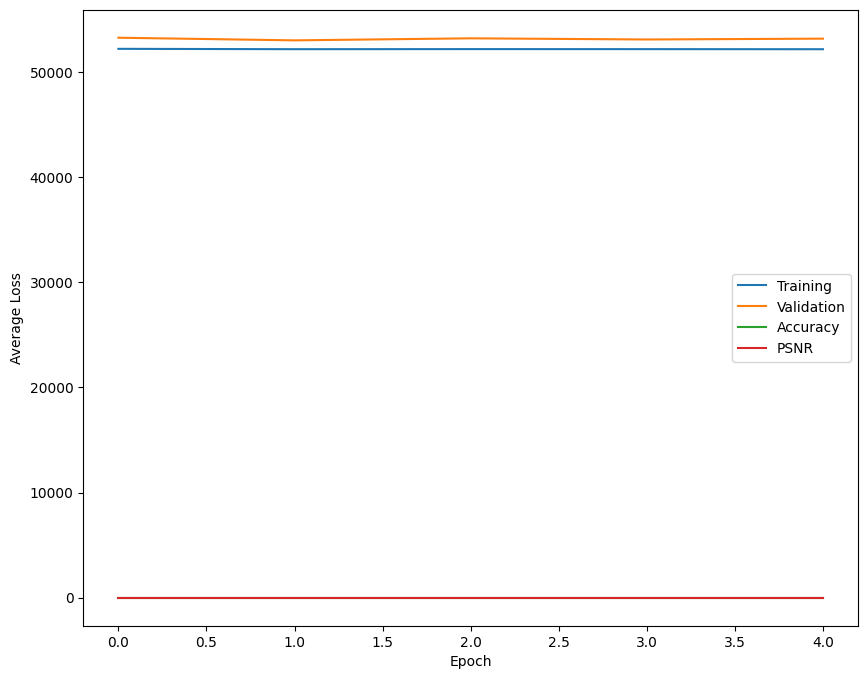

fold 2/3, epochs: 5, train loss: 52175.013491, valid loss: 53144.244586

-- Sample 1/5 Average Training Loss: 59,116.46
-- Sample 1/5 Difference with Validation: 3,383.08

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 139,465.901 V 139,357.427
	Loss at epoch 1: T 139,497.731 V 139,065.580
	Loss at epoch 2: T 139,496.115 V 139,069.924
	Loss at epoch 3: T 139,495.694 V 139,269.669
	Loss at epoch 4: T 139,480.519 V 139,367.032
Training process has finished.


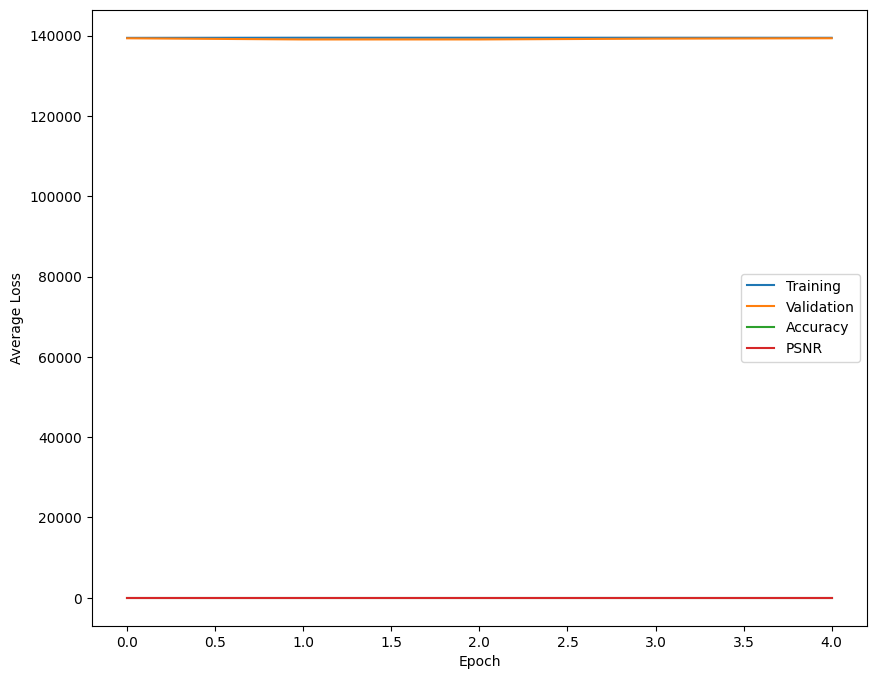

fold 0/3, epochs: 5, train loss: 139487.192153, valid loss: 139225.926115

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 139,382.975 V 139,245.669
	Loss at epoch 1: T 139,415.037 V 139,273.465
	Loss at epoch 2: T 139,372.555 V 139,239.669
	Loss at epoch 3: T 139,377.664 V 139,301.057
	Loss at epoch 4: T 139,354.026 V 139,227.911
Training process has finished.


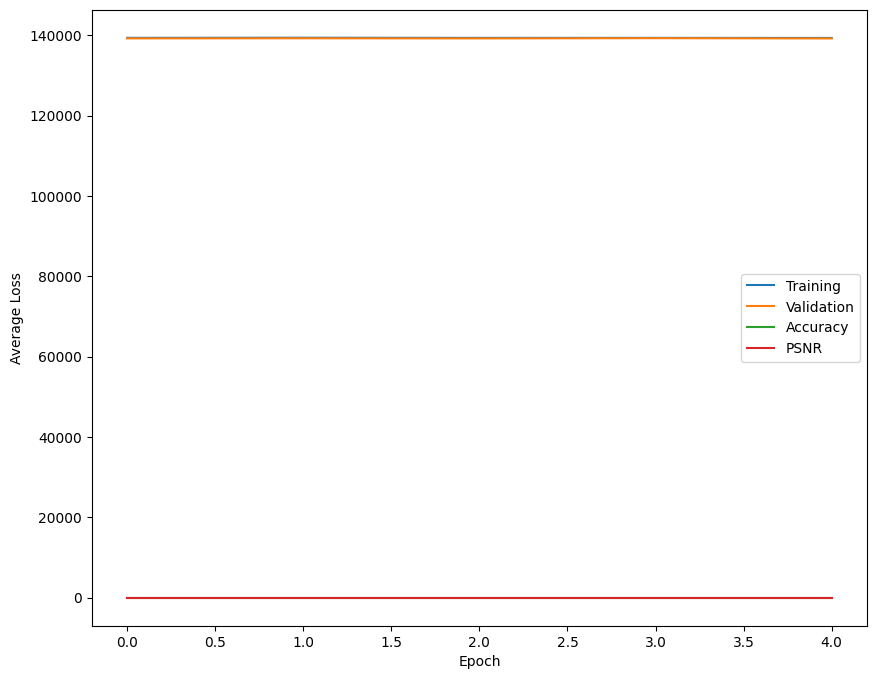

fold 1/3, epochs: 5, train loss: 139380.451338, valid loss: 139257.554140

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 139,204.179 V 139,567.885
	Loss at epoch 1: T 139,185.891 V 139,608.854
	Loss at epoch 2: T 139,197.493 V 139,493.847
	Loss at epoch 3: T 139,190.398 V 139,613.898
	Loss at epoch 4: T 139,225.597 V 139,501.439
Training process has finished.


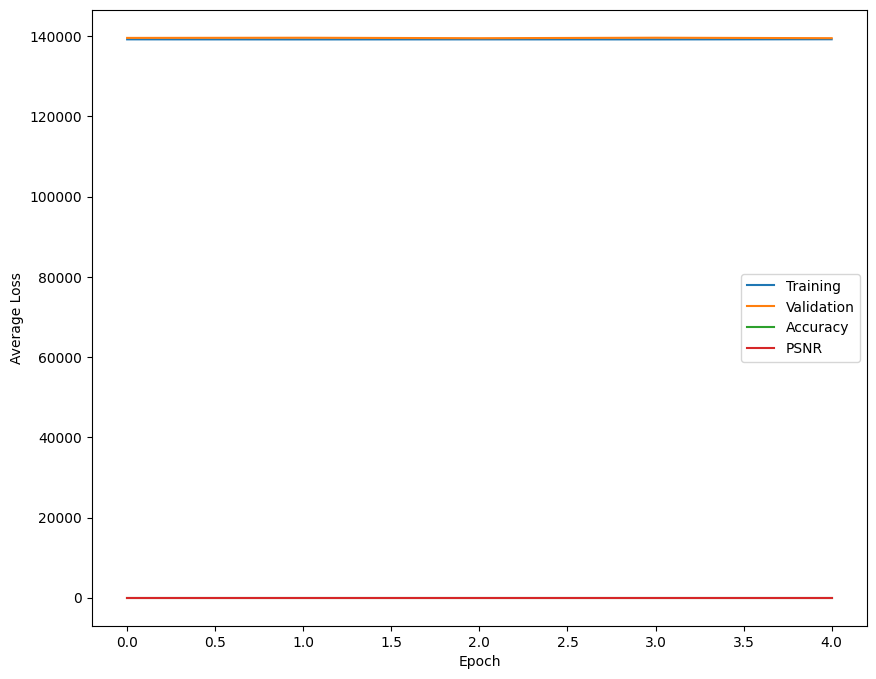

fold 2/3, epochs: 5, train loss: 139200.711636, valid loss: 139557.184713

-- Sample 2/5 Average Training Loss: 139,356.12
-- Sample 2/5 Difference with Validation: 9.23

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 139,579.024 V 140,412.150
	Loss at epoch 1: T 139,409.460 V 139,236.075
	Loss at epoch 2: T 139,734.633 V 139,374.587
	Loss at epoch 3: T 139,692.469 V 138,918.087
	Loss at epoch 4: T 139,378.611 V 139,601.900
Training process has finished.


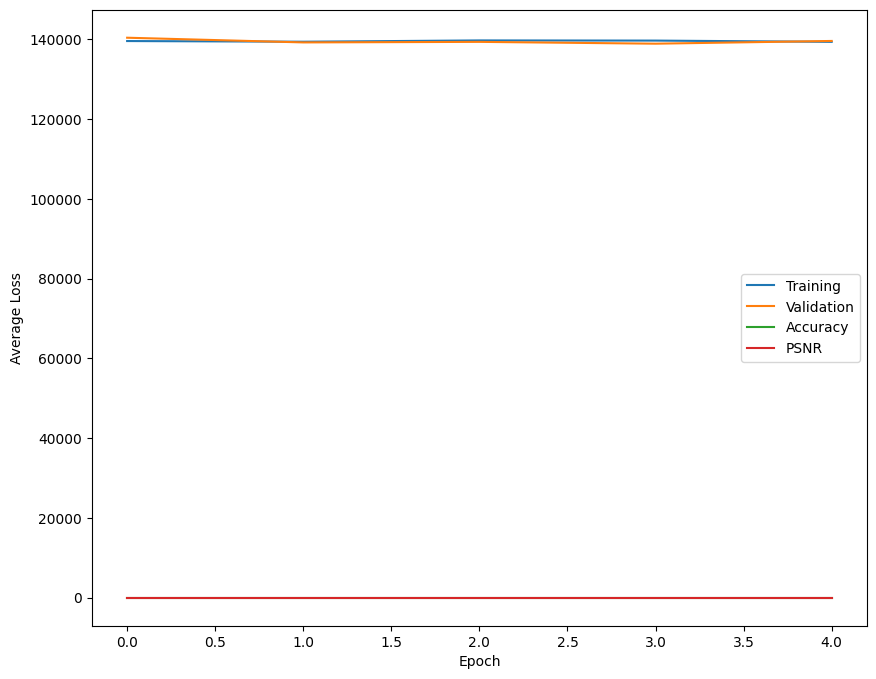

fold 0/3, epochs: 5, train loss: 139558.839458, valid loss: 139508.560000

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 139,338.131 V 139,805.625
	Loss at epoch 1: T 139,543.812 V 138,814.500
	Loss at epoch 2: T 139,322.671 V 139,176.638
	Loss at epoch 3: T 139,369.271 V 139,733.462
	Loss at epoch 4: T 139,352.977 V 138,826.812
Training process has finished.


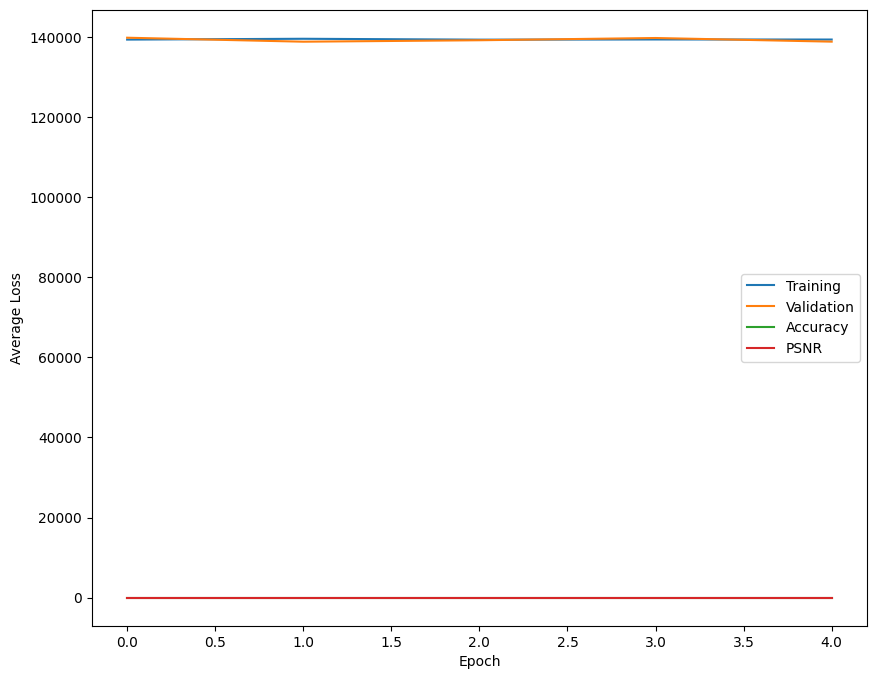

fold 1/3, epochs: 5, train loss: 139385.372468, valid loss: 139271.407500

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 139,398.662 V 139,637.850
	Loss at epoch 1: T 139,202.793 V 139,769.900
	Loss at epoch 2: T 139,302.759 V 139,406.462
	Loss at epoch 3: T 139,211.753 V 139,654.263
	Loss at epoch 4: T 139,526.800 V 139,657.288
Training process has finished.


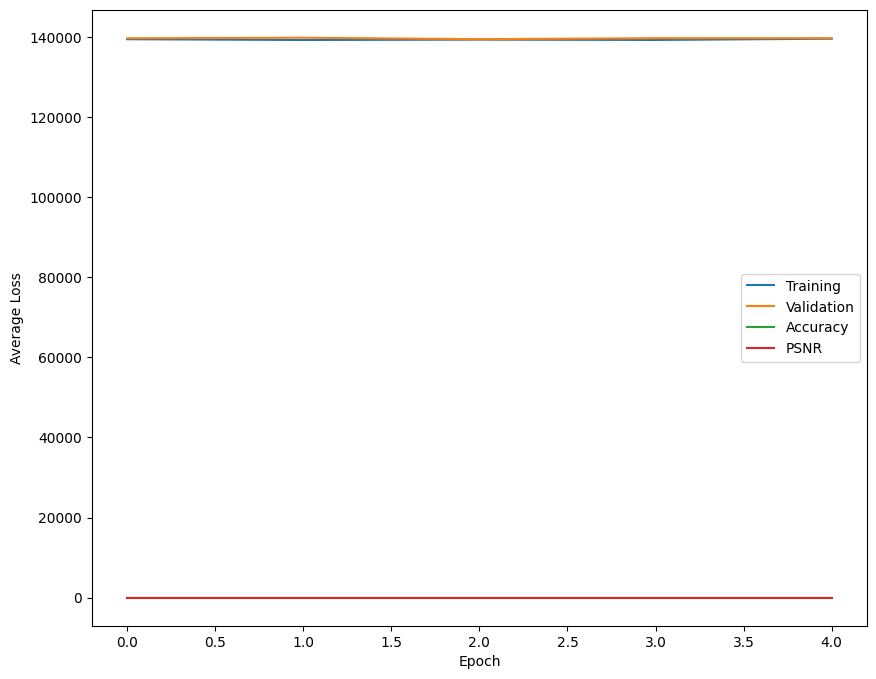

fold 2/3, epochs: 5, train loss: 139328.553224, valid loss: 139625.152500

-- Sample 3/5 Average Training Loss: 139,424.26
-- Sample 3/5 Difference with Validation: 44.12

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 113,160.589 V 56,831.069
	Loss at epoch 1: T 53,000.056 V 52,767.944
	Loss at epoch 2: T 52,245.879 V 53,121.088
	Loss at epoch 3: T 52,478.446 V 52,972.331
	Loss at epoch 4: T 52,646.376 V 52,763.556
Training process has finished.


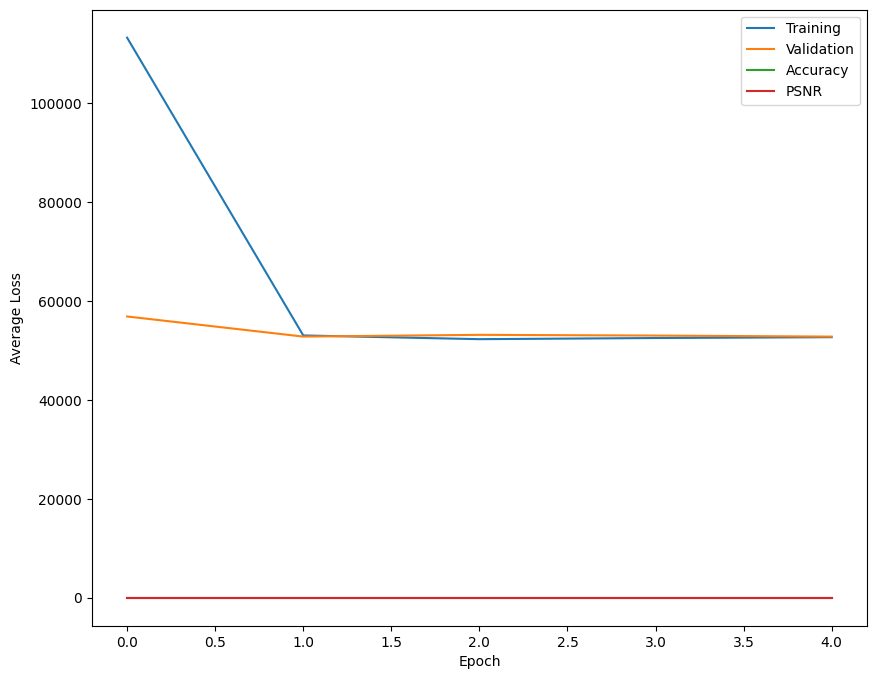

fold 0/3, epochs: 5, train loss: 64706.269017, valid loss: 53691.197500

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 52,909.959 V 51,620.575
	Loss at epoch 1: T 52,895.809 V 52,014.459
	Loss at epoch 2: T 52,791.283 V 51,456.188
	Loss at epoch 3: T 52,936.745 V 52,321.522
	Loss at epoch 4: T 52,774.951 V 52,485.113
Training process has finished.


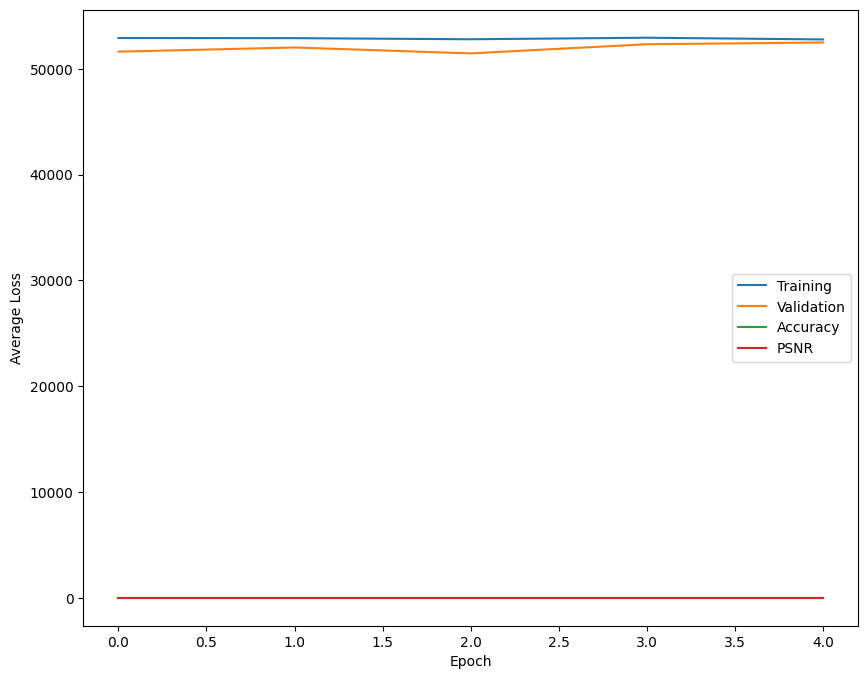

fold 1/3, epochs: 5, train loss: 52861.749486, valid loss: 51979.571250

No weights file found. Using randomly initialized weights.

Starting MLP model training for 5 epochs:
	Loss at epoch 0: T 52,198.402 V 52,784.375
	Loss at epoch 1: T 52,084.503 V 52,668.762
	Loss at epoch 2: T 52,173.388 V 53,070.950
	Loss at epoch 3: T 52,496.348 V 52,871.356
	Loss at epoch 4: T 52,017.256 V 52,990.844
Training process has finished.


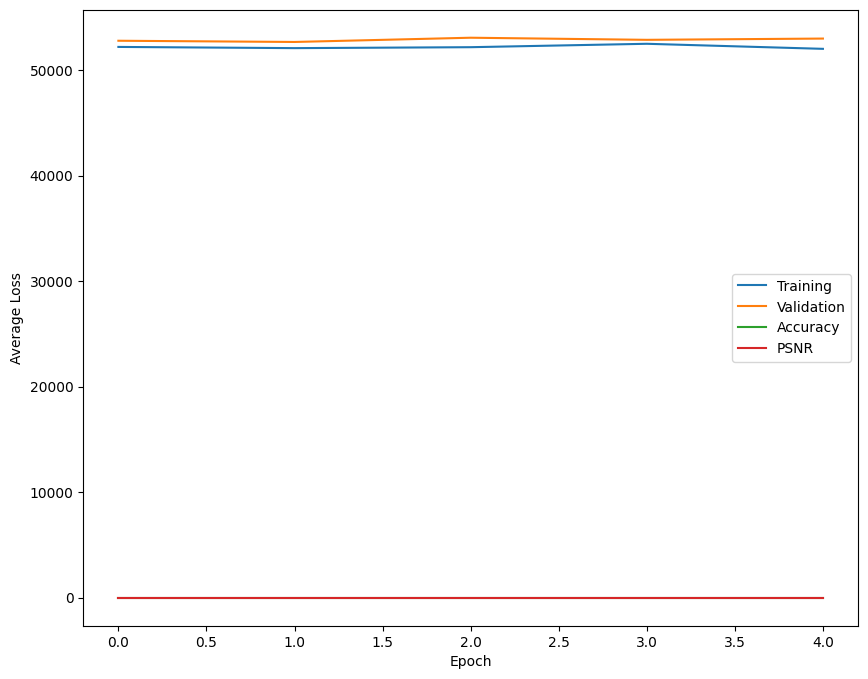

fold 2/3, epochs: 5, train loss: 52193.979509, valid loss: 52877.257500

-- Sample 4/5 Average Training Loss: 56,587.33
-- Sample 4/5 Difference with Validation: 3,737.99

The best set of hyperparameters from
Sample Size: 5 Folds: 3 Epochs: 5 is
Sample #4: 
	Average Loss 56,587.33 and 
	Variance 3,737.99.

Parameters: {'bsize': 256, 'lr': 0.31623, 'decay': 0.001, 'hidden': (120, 20, 140, 100, 40, 40, 80)}


In [59]:
def get_k_fold_data(k, i, combined_dataset):

    fold_size = len(combined_dataset) // k
    indices = list(range(len(combined_dataset)))

    val_indices = indices[i * fold_size: (i+1) * fold_size]
    train_indices = indices[:i * fold_size] + indices[(i+1) * fold_size:]

    train_subset = Subset(combined_dataset, train_indices)
    val_subset = Subset(combined_dataset, val_indices)

    return train_subset, val_subset

def is_list_of_type(lst,type=float):
  return all(isinstance(item, type) for item in lst)

def plot_curves( stats_dict, xlabel, ylabel, scale='log', title=None, exclude=[] ):

  # Plot losses
  plt.figure(figsize=(10,8))
  for (key, data) in stats_dict.items():
    if key not in exclude:
      if torch.is_tensor(data):
          data_np = data.numpy()
      elif is_list_of_type(data,float) or is_list_of_type(data,int):
          data_np = np.array(data)
      else:
        raise TypeError("Unable plot input data type.")

      # Using a log scale on y-axis by default
      if scale == 'log':
        plt.semilogy(data_np, label=key)
      else:
        plt.plot(data_np, label=key)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  if title:
    plt.title(title)
  plt.show()
# Choose random layers and nodes per layer
layers = np.arange(2,10,1)
nodes = np.arange(20,160,20)

# Choose random values for hyperparameters
bsize = [2**n for n in np.arange(6,10,1)]
lr = np.round(10**logScale(0.0001,1),5)
decay = np.round(10**logScale(0.001,0.2),5)

hyperparams = {'bsize':bsize,
               'lr':lr,
               'decay':decay
               }

# Choose experiment parameters
sample_size = 5
kfolds = 3
num_epochs = 5

# Find the best sample
results = []
best_result = sys.float_info.max
best_index = 0
i = 0

while i < sample_size:

  choice = RandomChoice(hyperparams)
  choice['hidden'] = RandomLayers(layers,nodes)

  model = MLP(hidden_layers=choice['hidden'],
              outputSize=1,
              lr=choice['lr'],
              lossfn=nn.MSELoss(reduction='sum'),
              target_type='float')

  model = model.to(device)
  avg_train_loss, avg_valid_loss = k_fold(k=kfolds,
                                          model=model,
                                          num_epochs=num_epochs,
                                          trainset=k_fold_trainset,
                                          batch_size=int(choice['bsize']),
                                          weight_decay=float(choice['decay']),
                                          learning_rate=int(choice['lr']),
                                          verbose=True,
                                          ignore_accuracy=True,
                                          input_as_target=False,
                                          compute_psnr=False)
  variance = abs(avg_train_loss-avg_valid_loss)

  print(f'-- Sample {i}/{sample_size} Average Training Loss: {avg_train_loss:,.2f}')
  print(f'-- Sample {i}/{sample_size} Difference with Validation: {variance:,.2f}\n')

  if avg_train_loss < best_result:
    best_result = avg_train_loss
    best_index = i

  results.append([avg_train_loss,variance,choice])
  i += 1

print(f'The best set of hyperparameters from')
print(f'Sample Size: {sample_size} Folds: {kfolds} Epochs: {num_epochs} is')
print(f'Sample #{best_index}: \n\tAverage Loss {results[best_index][0]:,.2f} and \n\tVariance {results[best_index][1]:,.2f}.\n')
print(f'Parameters: {results[best_index][2]}')

tuned_hparams = results[best_index][2]

In [60]:
if 'tuned_hparams' in globals():
  print("Using tuned hyperparameters:")
  print(f'{tuned_hparams}')
  model = MLP(hidden_layers=tuned_hparams['hidden'],
             outputSize=1,
             lr=float(tuned_hparams['lr']),
             lossfn=nn.MSELoss(),
             target_type='float')
  batch_size = int(tuned_hparams['bsize'])
  weight_decay = float(tuned_hparams['decay'])
else:
  print("No tuned hyperparameters found.")
  model = MLP(hidden_layers=(60, 140, 140, 100, 80, 40, 20, 140, 80),
             outputSize=1,
             lr=0.31623,
             lossfn=nn.MSELoss(),
             target_type='float')
  batch_size = 16
  weight_decay = 0.1

Using tuned hyperparameters:
{'bsize': 256, 'lr': 0.31623, 'decay': 0.001, 'hidden': (120, 20, 140, 100, 40, 40, 80)}


<class 'int'>
No weights file found. Using randomly initialized weights.

Starting MLP model training for 30 epochs:
	Loss at epoch 0: T 103,353.393 V 58,177.068
	Loss at epoch 1: T 52,311.914 V 53,679.109
	Loss at epoch 2: T 52,230.738 V 53,636.078
	Loss at epoch 3: T 52,230.734 V 53,606.417
	Loss at epoch 4: T 52,199.388 V 53,647.526
	Loss at epoch 5: T 52,187.393 V 53,543.594
	Loss at epoch 6: T 52,184.377 V 53,504.677
	Loss at epoch 7: T 52,198.405 V 53,553.328
	Loss at epoch 8: T 52,218.125 V 53,393.250
	Loss at epoch 9: T 52,184.507 V 53,414.307
	Loss at epoch 10: T 52,234.957 V 53,637.536
	Loss at epoch 11: T 52,208.139 V 53,685.510
	Loss at epoch 12: T 52,250.365 V 53,454.922
	Loss at epoch 13: T 52,215.591 V 53,497.458
	Loss at epoch 14: T 52,241.188 V 53,503.401
	Loss at epoch 15: T 52,215.836 V 53,534.344
	Loss at epoch 16: T 52,228.834 V 53,714.214
	Loss at epoch 17: T 52,196.202 V 53,554.042
	Loss at epoch 18: T 52,213.314 V 53,521.677
	Loss at epoch 19: T 52,201.399 V 53,

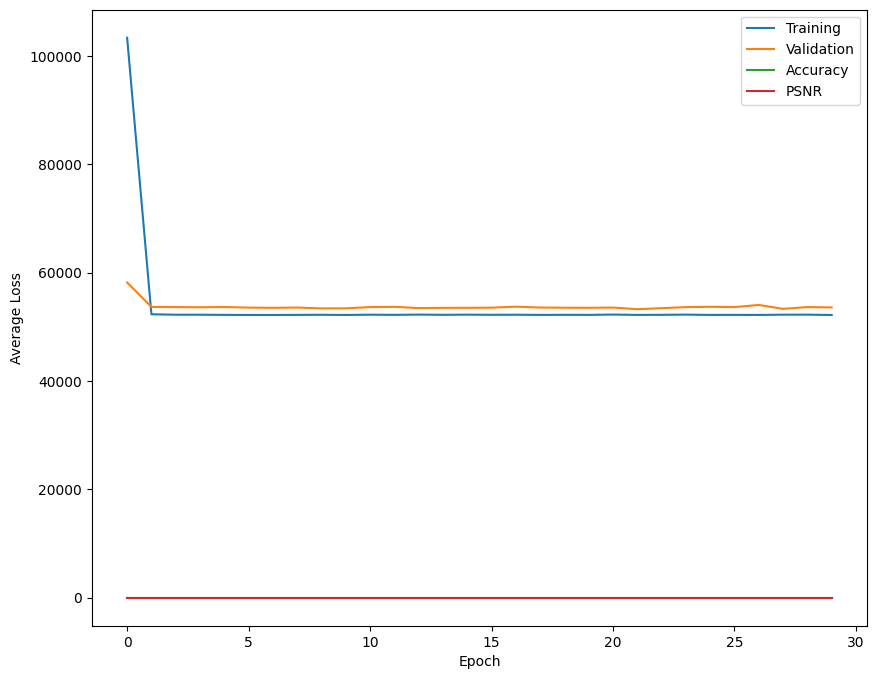

In [61]:
model = model.to(device)
print(type(batch_size))
_, _, checkpoint = train(model,
                         n_epochs=30,
                         train_dataset=train_dataset,
                         val_dataset=val_dataset,
                         batch_size=batch_size,
                         weight_decay=weight_decay,
                         writer=None,
                         new_lr=None,
                         use_saved_weights=False,
                         # To show epoch loss changes, set to True
                         verbose=True,
                         # For autoencoder, set to True
                         ignore_accuracy=True,
                         # set this to true for autoencoder
                         input_as_target=False,
                         # set this to true for autoencoder
                         compute_psnr=False)


# Models Training and Testing
## RandomForest

In [ ]:
# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
X_train_features = model.extract_features(trainset.X.to(device), layer_name=layer_name)
print(X_train_features.shape)
# grid = BayesSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid = RandomForestRegressor(n_estimators=500, random_state=42)
grid.fit(X_train_features, y_train_full)
train_pred = grid.predict(X_train_features)
if target_y == 'log_price':
    train_pred = np.expm1(train_pred * log_price_std + log_price_mean)
print(cross_val_score(grid, X_train_features, y_train_full, cv=3, scoring='neg_mean_absolute_error'))

print(mean_absolute_error(y_train_full, train_pred))
# print(grid.best_params_)
# print(grid.best_score_)
# print(grid.best_estimator_)



# # predict
# X_test_feature = model.extract_features(test_dataset.X.to(device), layer_name=layer_name)
# y_pred = grid.predict(X_test_feature)
# if target_y == 'log_price':
#     y_pred = np.expm1(y_pred * log_price_std + log_price_mean)
# to_submission_csv(y_pred)

## CatBoost

In [ ]:
# param_grid = {
#     'depth': [7, 10],
#     'learning_rate' : [0.3],
#     'l2_leaf_reg': [1, 4, 9],
#     'iterations': [750],
#     'task_type': ['GPU']
# }
# grid = BayesSearchCV(cb.CatBoostRegressor(), param_grid, cv=3, scoring='neg_mean_absolute_error')
# # grid = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
# X_train_features = model.extract_features(trainset.X.to(device), layer_name=layer_name)
# print(X_train_features.shape)

# grid.fit(X_train_features, y_train_full.numpy())
                  
# train_pred = grid.predict(X_train_features)
# if target_y == 'log_price':
#     train_pred = np.expm1(train_pred * log_price_std + log_price_mean)
    
# print(mean_absolute_error(y_train_full, train_pred))
# print(grid.best_params_)
# print(grid.best_score_)
# print(grid.best_estimator_)

# # predict
# X_test_feature = model.extract_features(test_dataset.X.to(device), layer_name=layer_name)
# y_pred = grid.predict(X_test_feature)
# if target_y == 'log_price':
#     y_pred = np.expm1(y_pred * log_price_std + log_price_mean)
# to_submission_csv(y_pred)

## XGBoost

In [ ]:
# param_grid = {
#         'objective':['reg:absoluteerror'],
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5],
#         'device':['gpu']
#         }

# grid = BayesSearchCV(xgb.XGBRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
# # grid = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
# X_train_features = model.extract_features(trainset.X.to(device), layer_name=layer_name)
# print(X_train_features.shape)

# grid.fit(X_train_features, y_train_full)
                  
# train_pred = grid.predict(X_train_features)
# if target_y == 'log_price':
#     train_pred = np.expm1(train_pred * log_price_std + log_price_mean)
    
# print(mean_absolute_error(y_train_full, train_pred))
# print(grid.best_params_)
# print(grid.best_score_)
# print(grid.best_estimator_)

# # predict
# X_test_feature = model.extract_features(test_dataset.X.to(device), layer_name=layer_name)
# y_pred = grid.predict(X_test_feature)
# if target_y == 'log_price':
#     y_pred = np.expm1(y_pred * log_price_std + log_price_mean)
# to_submission_csv(y_pred)

## MLP Testing

In [ ]:
# # Change the model to evaluation mode
# model.eval()

# test_loader = DataLoader(test_dataset,
#                          shuffle=True,
#                          batch_size=1,
#                          num_workers=2)

# # Retrieve the original test data
# test_data  = pd.read_csv('/content/drive/MyDrive/data/X_test.csv')
# test_ids = test_data['Index']
# test_prediction = []

# # this is for house price prediction from Kaggle data
# # so no labels in the test set
# with torch.no_grad():
#   # iterate over the DataLoader for training data
#   for i, data in enumerate(test_loader,0):
#     inputs = data.to(device)
#     # Now, let's see what the network thinks these examples are
#     prediction = model(inputs)
#     # unnormalized = 10**prediction
#     test_prediction.append(prediction.item())
#       # print(predicted)
# #    print(f'{i} : {unnormalized.item():,.2f}')

# # convert test_ids to a dataframe
# submission = pd.DataFrame(test_ids)
# submission['Price'] = test_prediction

# print(submission.shape)
# submission.to_csv('/content/drive/MyDrive/data/predictions.csv',index=False)